In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
from scipy import interpolate
file_name = "more2/connect_two_spectrometers.h5"
h5_file = h5py.File(file_name, "r")

In [2]:
def create_list_of_datasets_in_h5file(h5_file):
    """
    Returns a list of the paths of all datasets in an h5 file.
    Can also be used to list all datasets under a given node (e.g., f['session001']).  In this case,
    the 'session001' is not included in the output paths.
    This comes from:
    https://stackoverflow.com/questions/44883175/how-to-list-all-datasets-in-h5py-file
    :param f:
    :return:
    """
    keys = []
    h5_file.visit(lambda key: keys.append(key) if type(h5_file[key]) is h5py._hl.dataset.Dataset else None)
    return keys


def create_list_of_groups_in_node(node):
    keys = []
    node.visit(lambda key: keys.append(key) if type(node[key]) is h5py._hl.group.Group else None)
    return keys

def create_list_of_items_in_node(item_type, h5_file, node):
    keys = []
    if item_type == "group":
        my_type = h5py._hl.group.Group
    if item_type == "dataset":
        my_type = h5py._hl.dataset.Dataset
    h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
    return keys

def create_list_of_insertions_in_node(h5_file, node):
    insertions = []
    all_groups = create_list_of_items_in_node("group", h5_file, node)
    for group in all_groups:
        if group[-6:-3] == 'ins':
            insertions.append(group)
    return insertions

def create_session_insertion_dict(h5_file):
    keys = list(h5_file.keys())
    key_dict = {}
    for key in keys:
        # session_number = int(key[-3:])
        key_dict[key] = create_list_of_insertions_in_node(h5_file, key)
    print(key_dict)
    return key_dict

def create_list_of_calibrations_in_node(h5_file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", h5_file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(group)
    return calibrations


def create_session_calibration_dict(h5_file):
    keys = list(h5_file.keys())
    key_dict = {}
    for key in keys:
        key_dict[key] = create_list_of_calibrations_in_node(h5_file, key)
    print(key_dict)
    return key_dict

def get_wavelengths_vector(h5_file, session, insertion, spectrometer):
    if spectrometer == "spectrometer1":
        vector_attr = "spec1_wavelengths_vector"
    elif spectrometer == "spectrometer2":
        vector_attr = "spec2_wavelengths_vector"
    else:
        print("spectrometer not specified")
        vector_attr = ""

    insertion_group = h5_file[f"{session}/{insertion}"]
    wavelengths_vector = insertion_group.parent.attrs[vector_attr][:]
    return wavelengths_vector

def get_absorbance_spectra_in_insertion(h5_file, session, insertion):
    absorbance_string = "spectrometer1/derived/absorbances"
    absorbance_spectra = h5_file[f"{session}/{insertion}/{absorbance_string}"][:]
    print(absorbance_spectra)
    return absorbance_spectra

def get_absorbance_spectra_and_depth_in_insertion(h5_file, session, insertion):
    dset_string = "derived/absorbance_depth"
    dset = h5_file[f"{session}/{insertion}/{dset_string}"]
    absorbance_spectra = dset[:, :-2]
    depths = dset[:, -1]
    forces = dset[:, -2]
    print(absorbance_spectra)
    return absorbance_spectra, depths, forces

def get_current_time():
    return np.datetime64(datetime.datetime.now()).astype(np.int64)


def timestamp_list_to_pandas_timestamps(timestamp_list):
    series = pd.Series(timestamp_list).astype('<M8[us]')
    return series

def find_zoomed_yvalues(wavelengths_vector, absorbance_spectrum):
    
    # get min_val, max_val of 1700 to 1800 nm
    mid_waves = (wavelengths_vector > 1700) & (wavelengths_vector < 1800)
    minval = absorbance_spectrum[mid_waves].min()
    maxval = absorbance_spectrum[mid_waves].max()
    ymin = minval - (minval * 0.01)
    ymax = maxval + (maxval * 0.01)
    return ymin, ymax

## Session 008
Session 008 was the intial testing of the soil cylinders, using a cylinder with lard-spiked soil in layers.

There were two insertions.  The first one was done at a velocity of 10 mm/sec, the second at 15 mm/sec.

In [26]:
inserts = create_list_of_insertions_in_node(h5_file, "session008")
waves = h5_file['session008/cal001'].attrs['spec1_wavelengths_vector'][:]
cols = waves.tolist()
cols.append('force')
cols.append('depth')
dfs = []
for i in range(len(inserts)):
    df_name = f"df{i+1}"
    dfs.append(df_name)
absorb_str = 'derived/absorbance_depth'
for i in range(len(inserts)):
    dfs[i] = pd.DataFrame(data = h5_file[f'session008/{inserts[i]}/{absorb_str}'][:], columns=cols)

## Plot all absorbance spectra by insertion, session 008

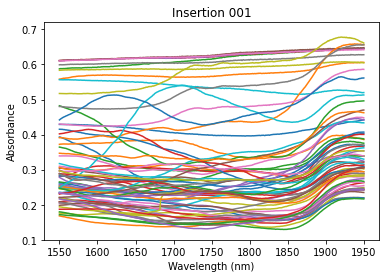

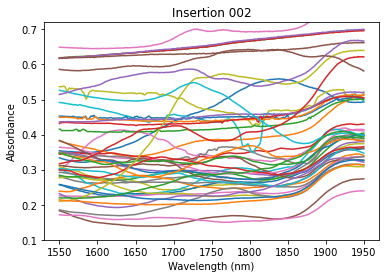

In [4]:
for i in range(len(dfs)):
    fig, ax = plt.subplots()
    ax.set_ylim(0.10, 0.72)
    ax.set_ylabel("Absorbance")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_title(f"Insertion {(i + 1):03d}")
    for spectrum in range(dfs[i].shape[0]):
        ax.plot(waves, dfs[i].iloc[spectrum, :-2])
    plt.show()

## Plot force by depth for each insertion (session 008)

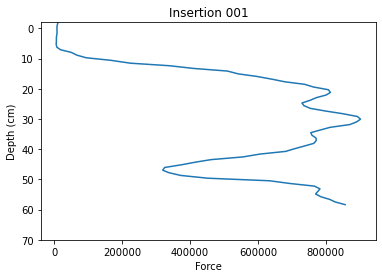

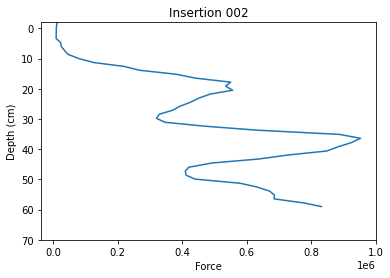

In [5]:
for i in range(len(dfs)):
    fig, ax = plt.subplots()
    ax.set_ylim(70.0, -2.0)
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel("Force")
    ax.set_title(f"Insertion {(i + 1):03d}")
    
    force = dfs[i].loc[:, "force"]
    
    depth = dfs[i].loc[:, "depth"]
    ax.plot(force, depth)

## Plot individual absorbance spectra (session 008)

This set of spectra are set to show the entire spectrum on a standard set of axes for all spectra.

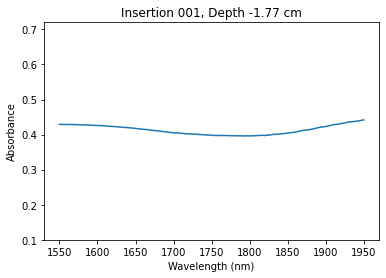

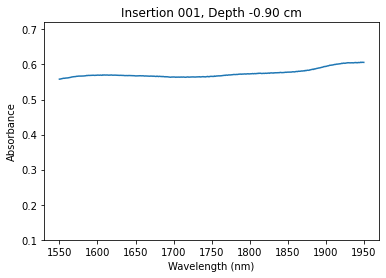

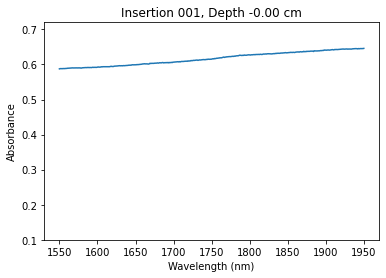

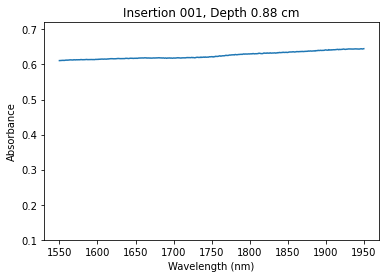

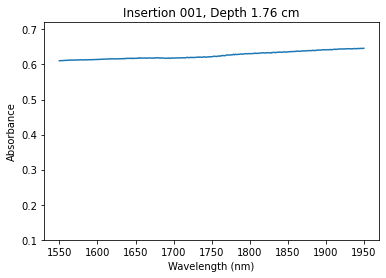

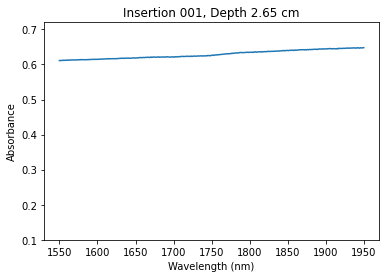

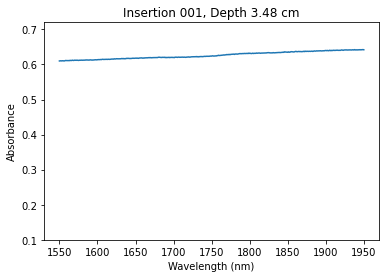

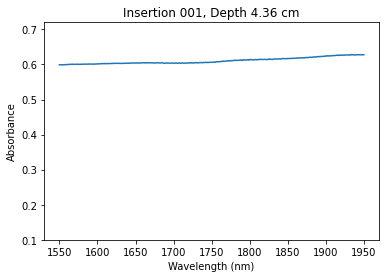

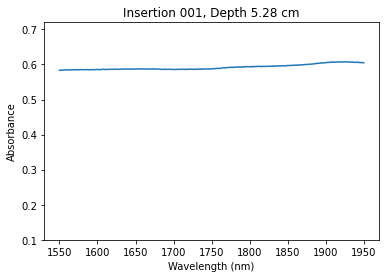

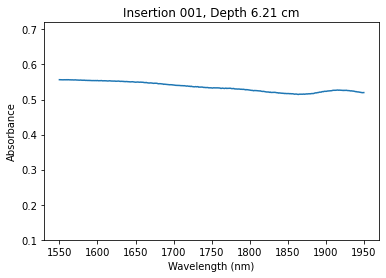

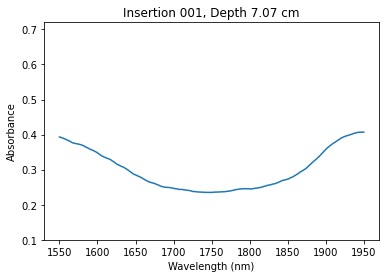

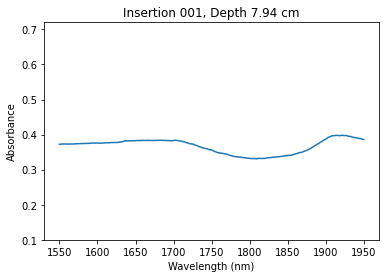

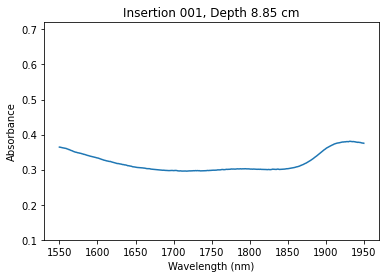

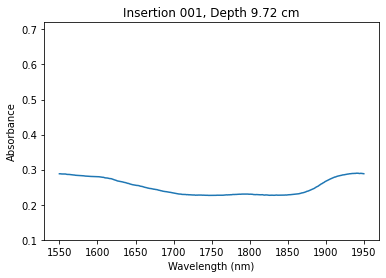

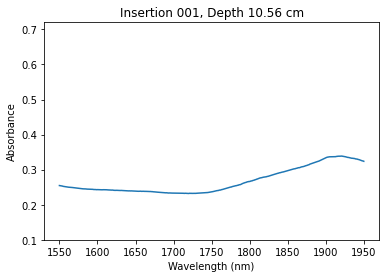

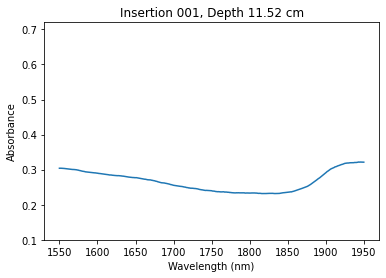

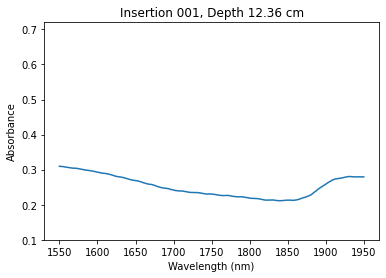

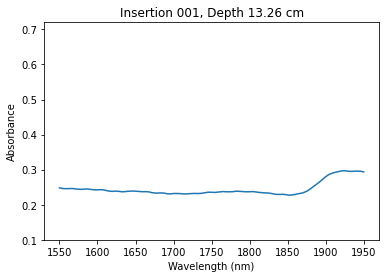

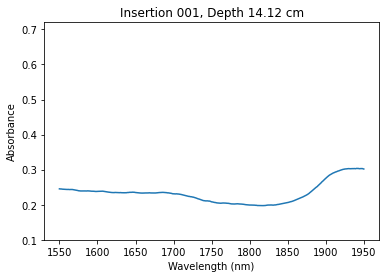

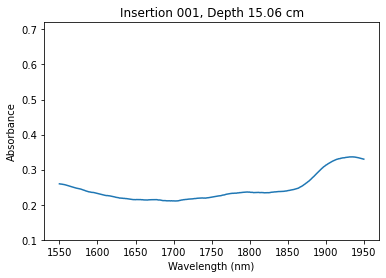

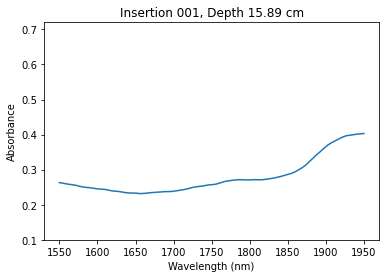

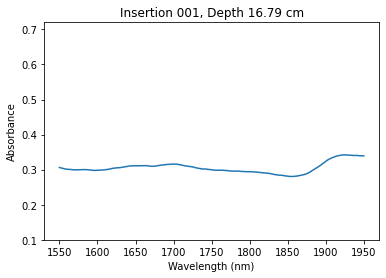

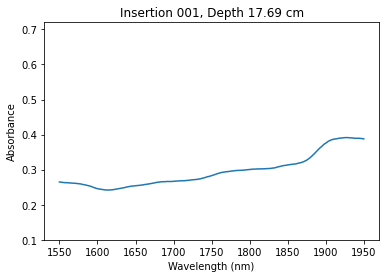

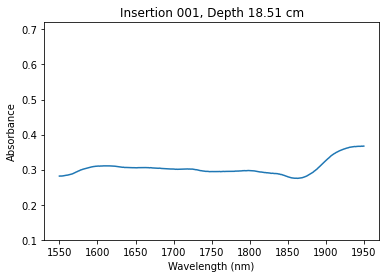

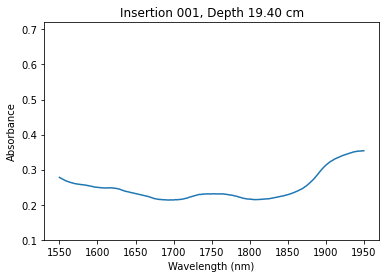

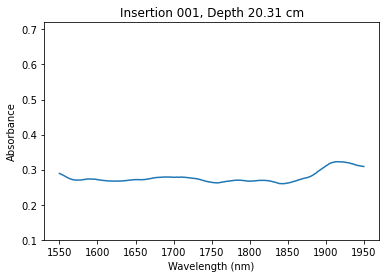

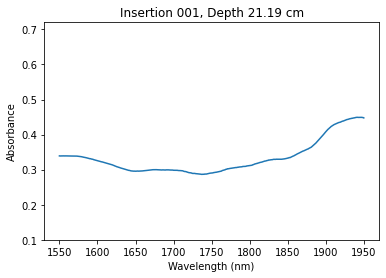

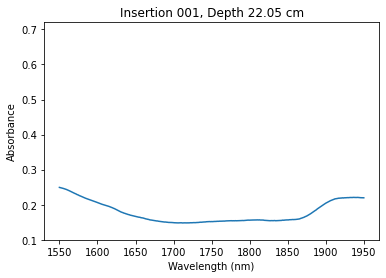

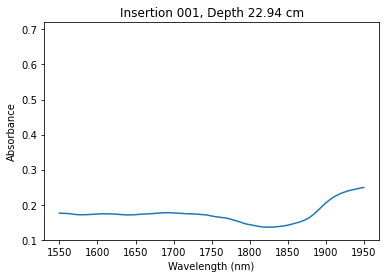

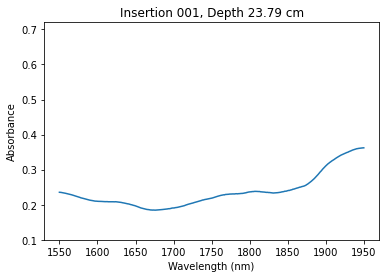

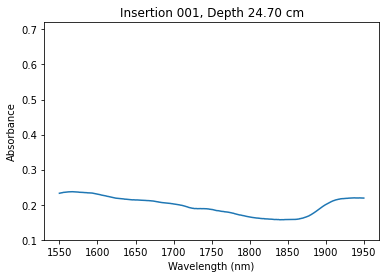

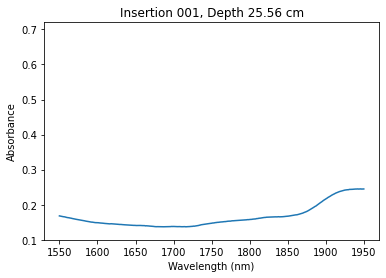

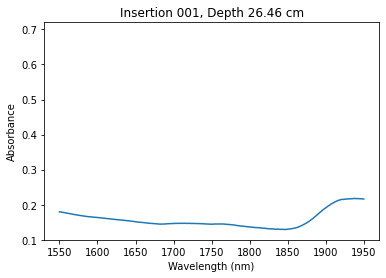

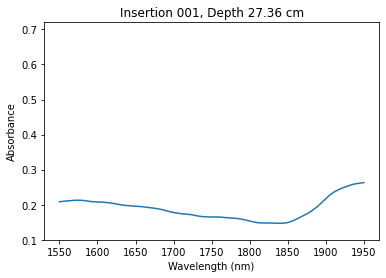

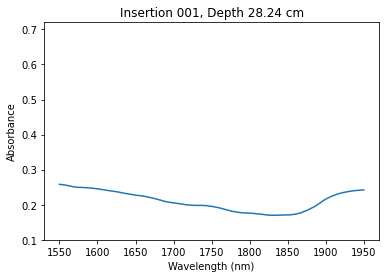

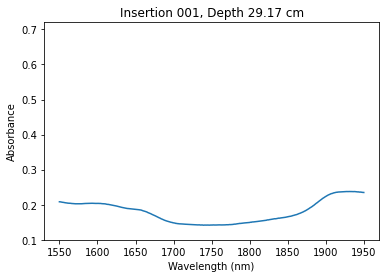

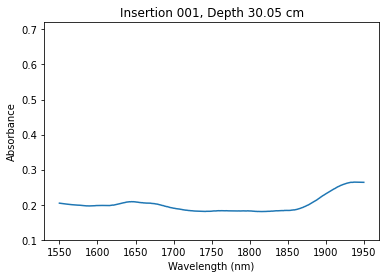

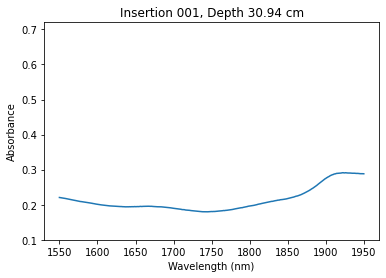

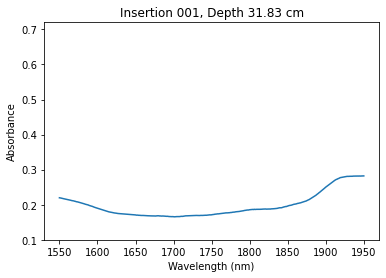

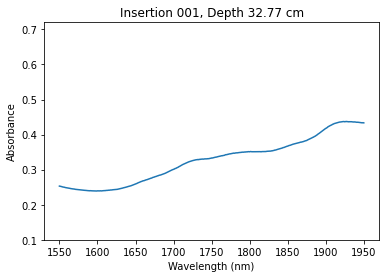

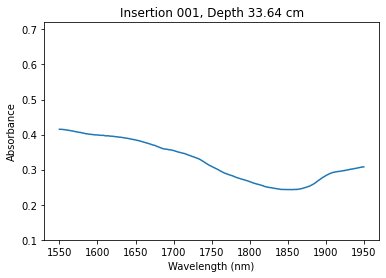

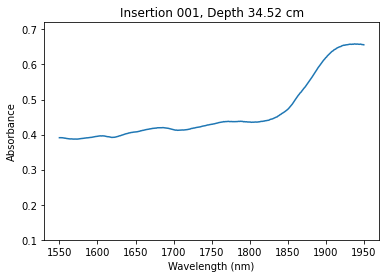

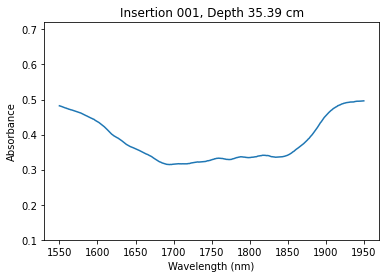

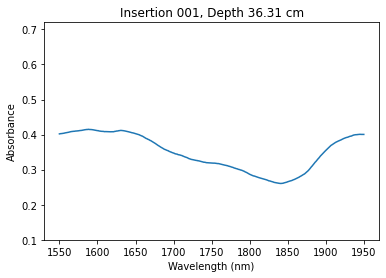

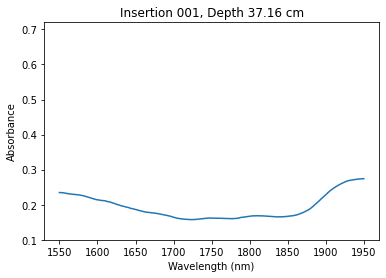

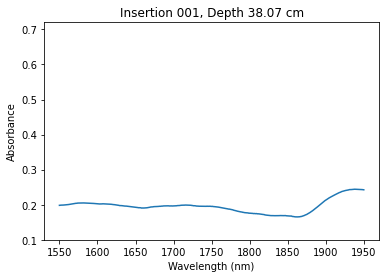

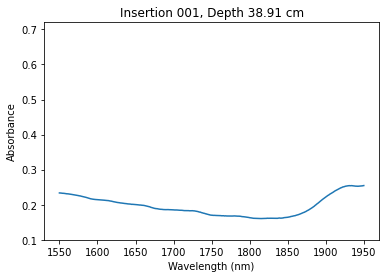

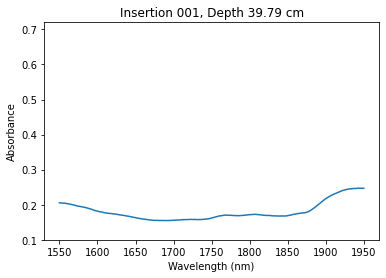

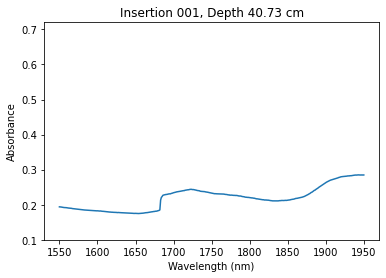

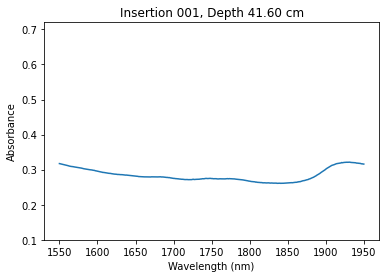

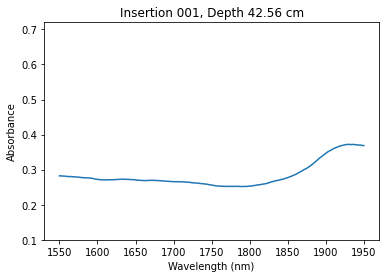

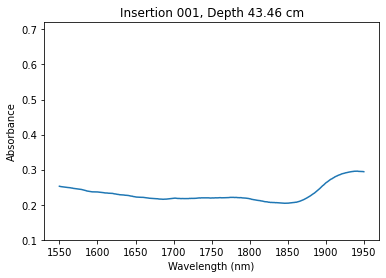

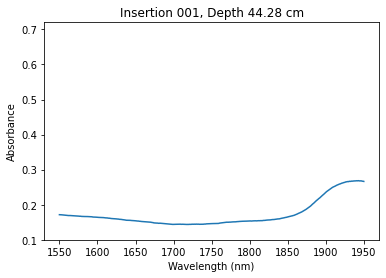

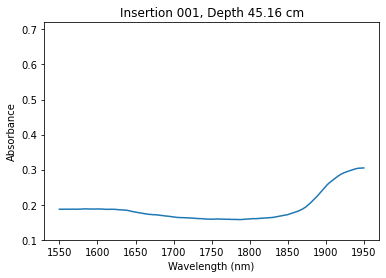

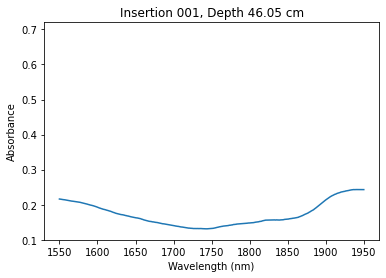

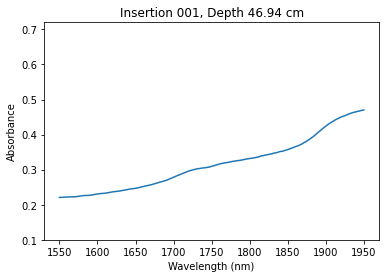

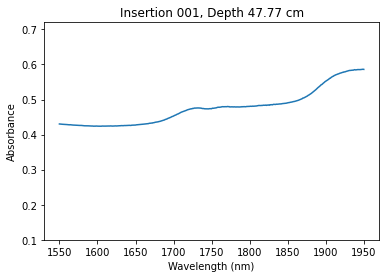

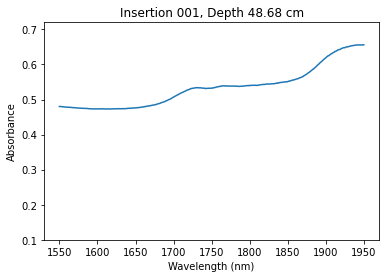

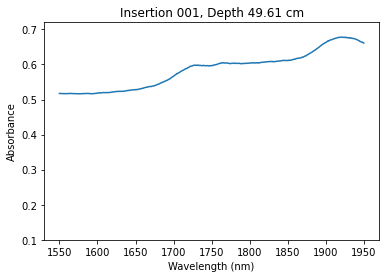

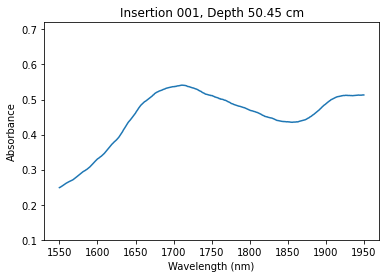

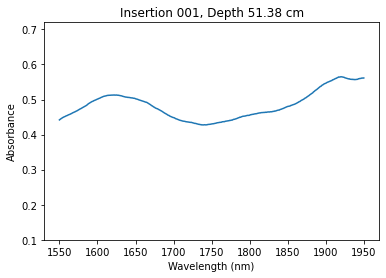

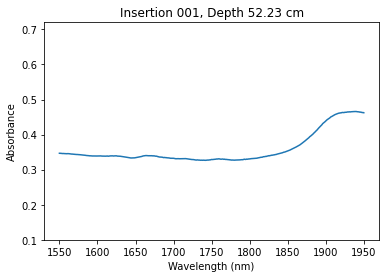

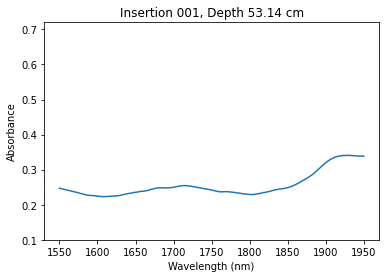

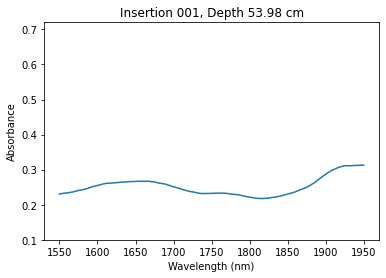

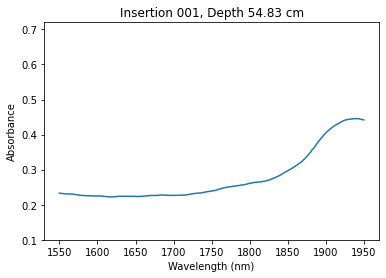

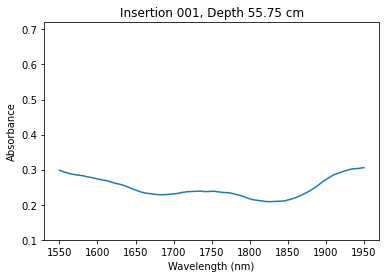

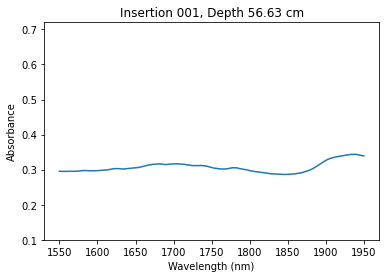

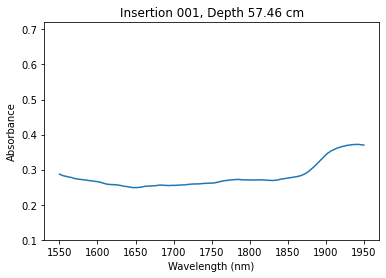

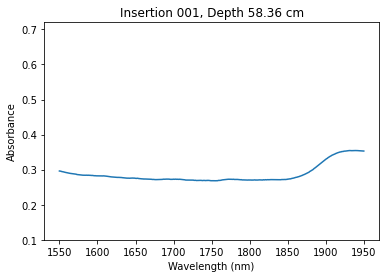

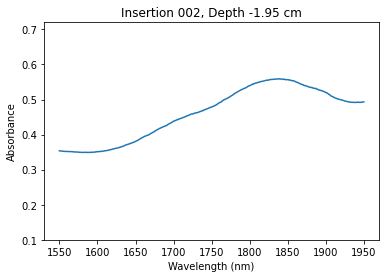

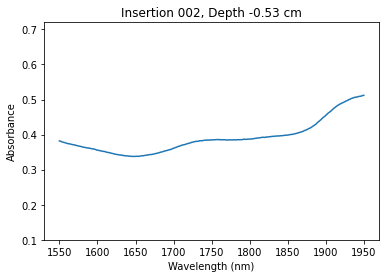

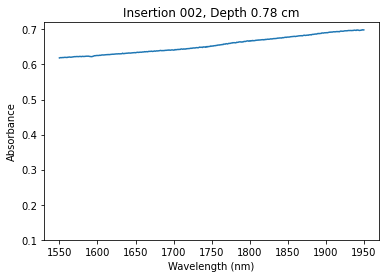

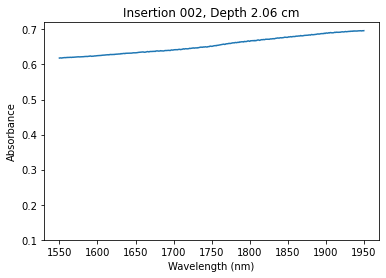

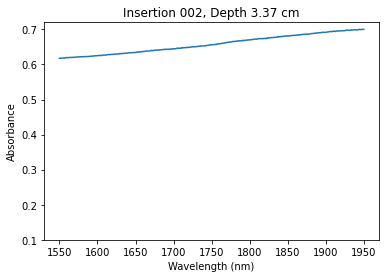

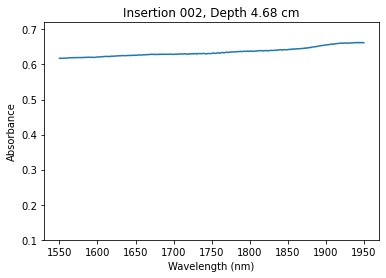

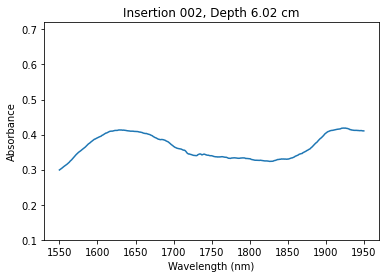

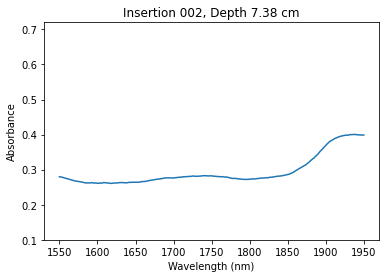

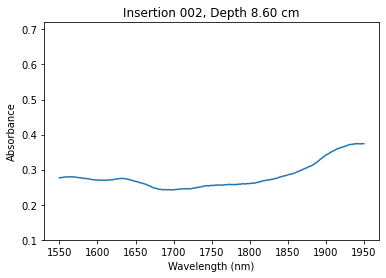

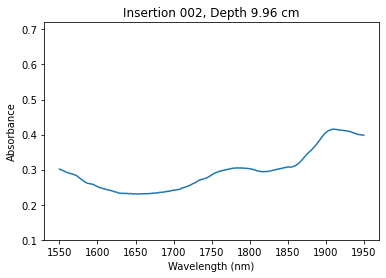

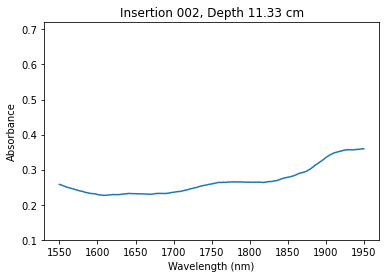

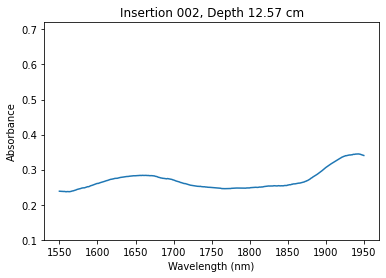

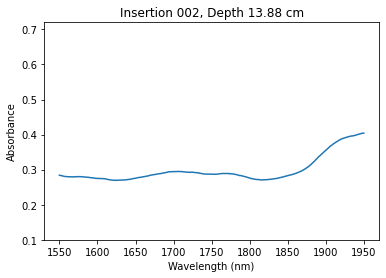

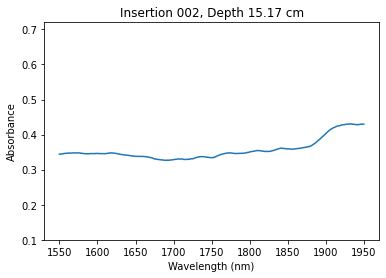

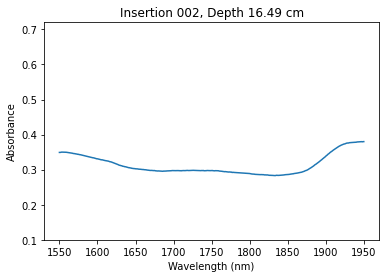

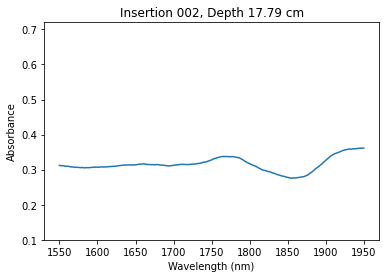

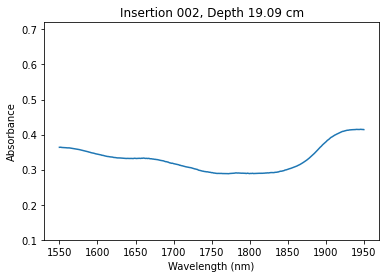

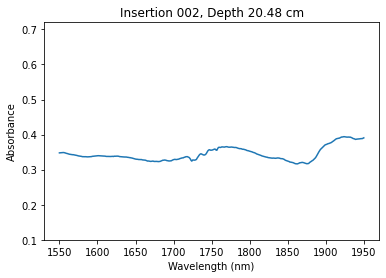

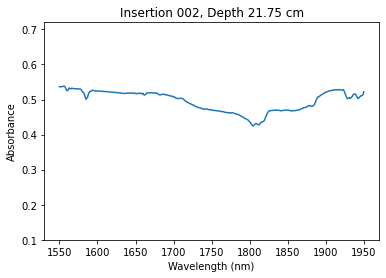

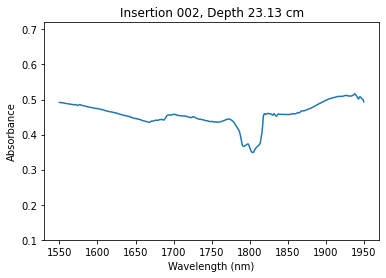

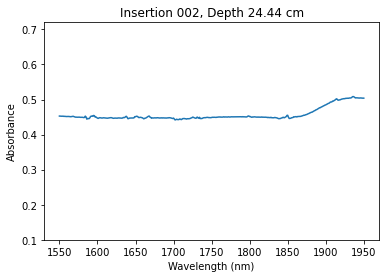

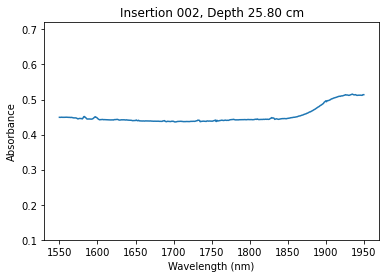

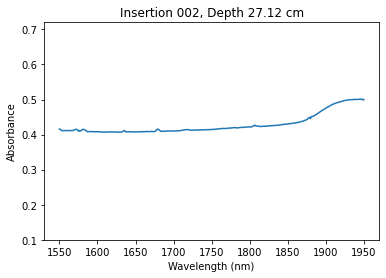

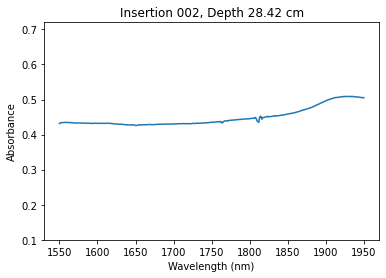

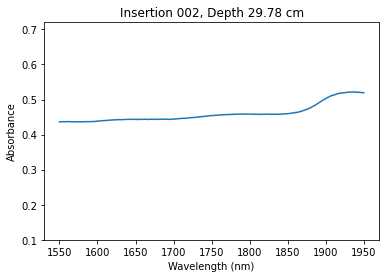

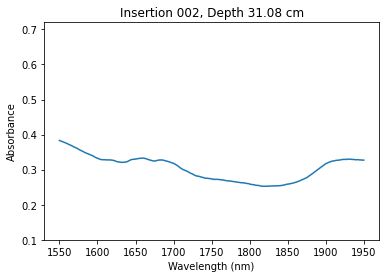

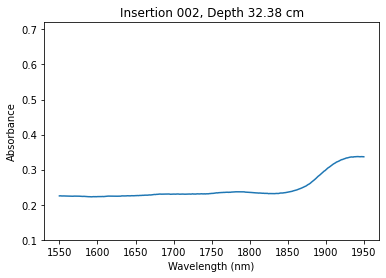

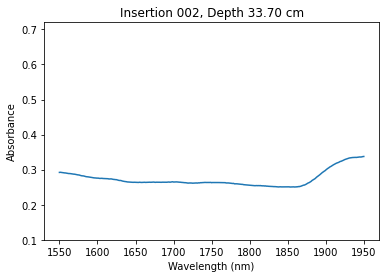

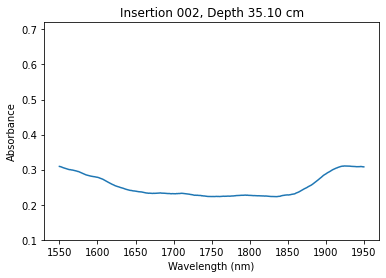

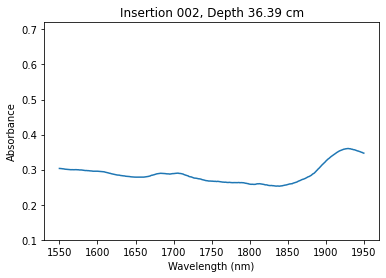

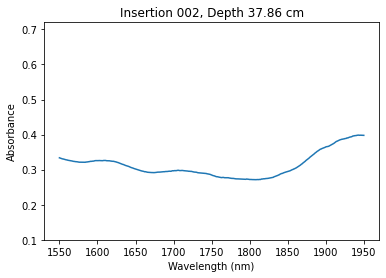

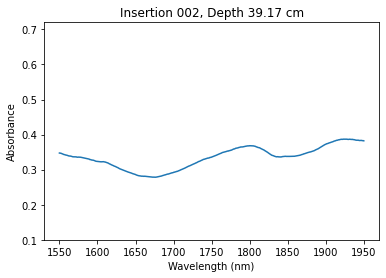

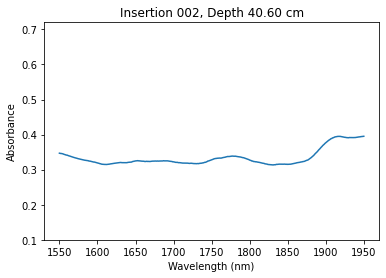

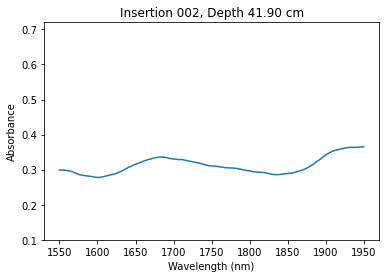

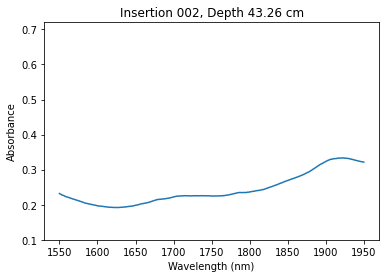

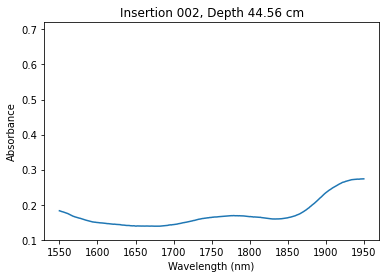

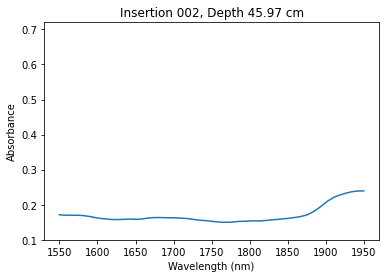

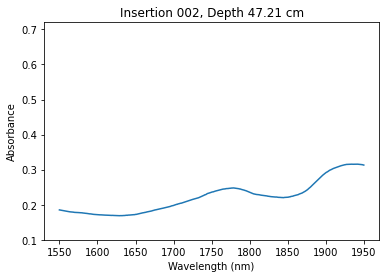

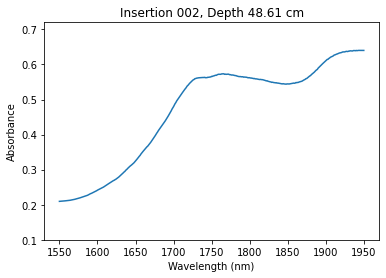

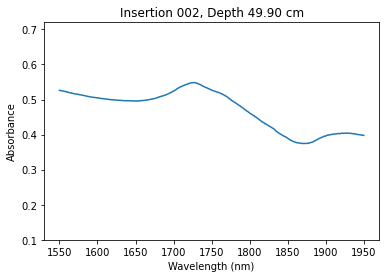

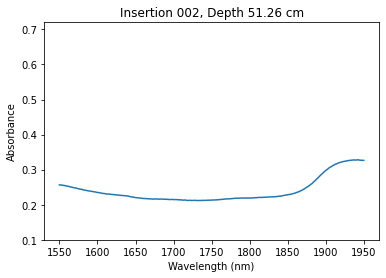

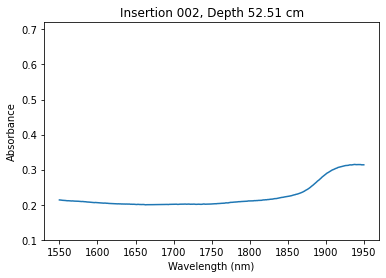

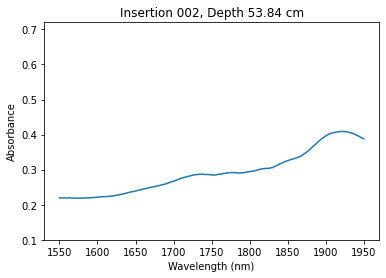

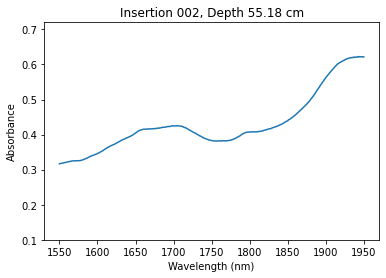

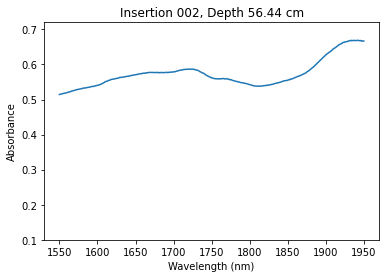

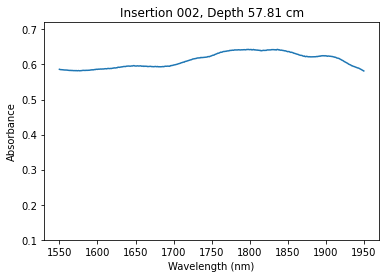

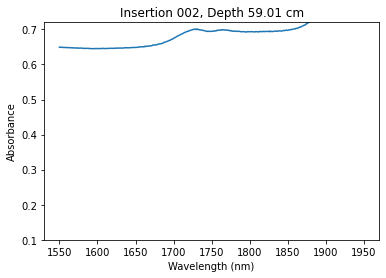

In [6]:
for i in range(len(dfs)):  
    for spectrum in range(dfs[i].shape[0]):
        fig, ax = plt.subplots()
        ax.set_ylim(0.10, 0.72)
        ax.set_ylabel("Absorbance")
        ax.set_xlabel("Wavelength (nm)")
        ax.set_title(f"Insertion {(i + 1):03d}, Depth {dfs[i].iloc[spectrum, -1]:0.2f} cm")
        ax.plot(waves, dfs[i].iloc[spectrum, :-2])
        plt.show()

## Plot individual absorbance spectra (session 008), with scale zoomed to show 1700 to 1800 nm better

We expect to hit the lard-spiked layers beginning around 9 cm, again at about 25 cm, and the third one at about 40 cm

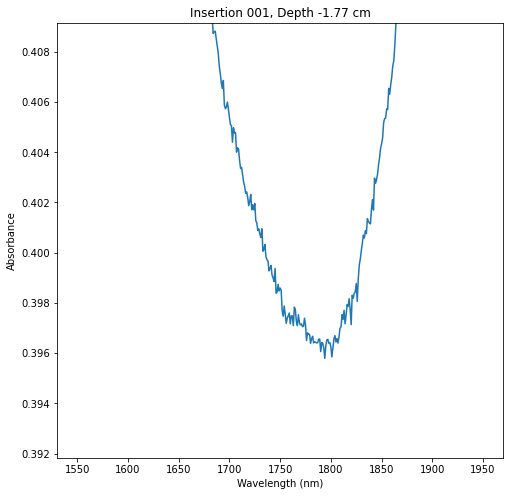

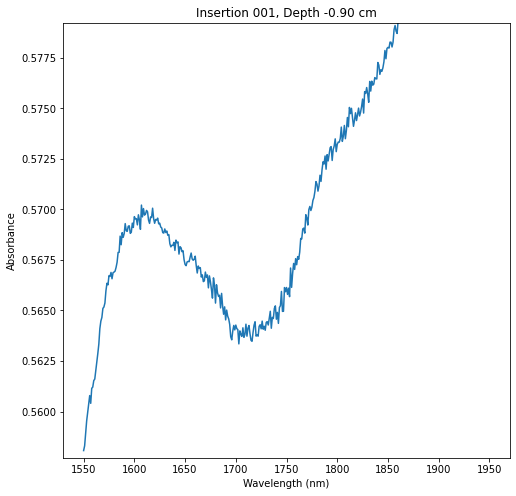

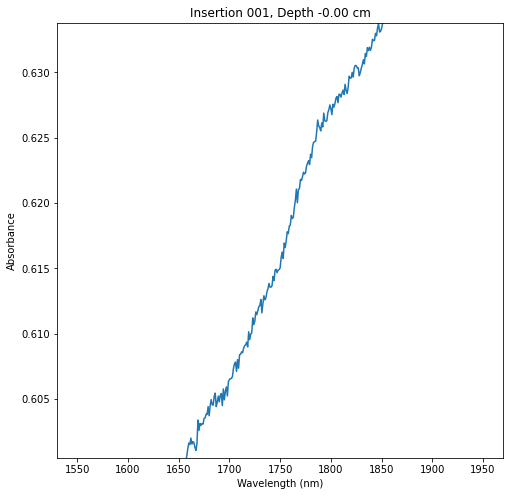

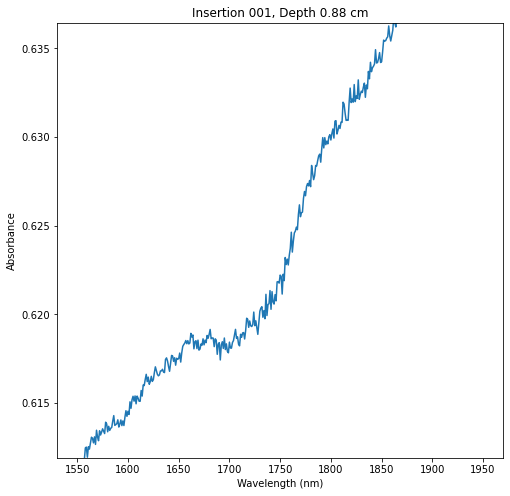

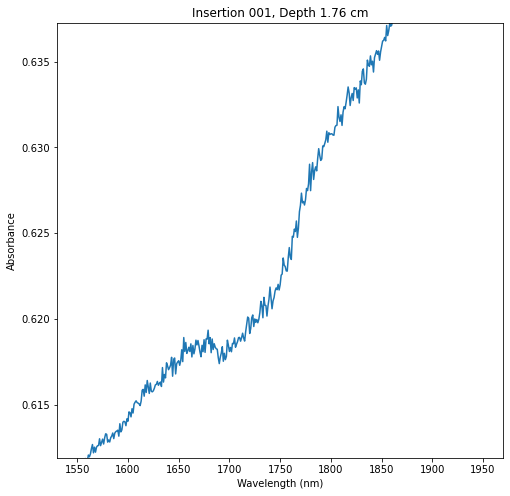

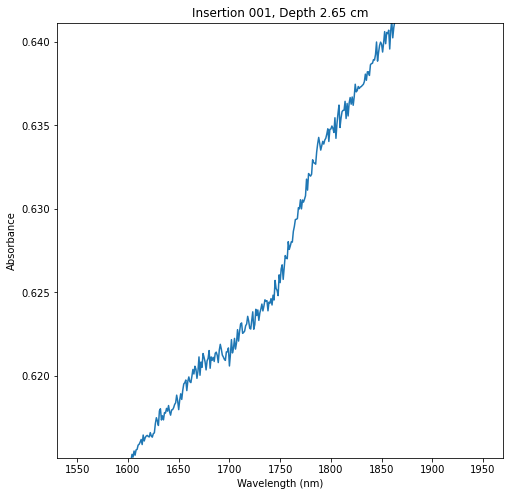

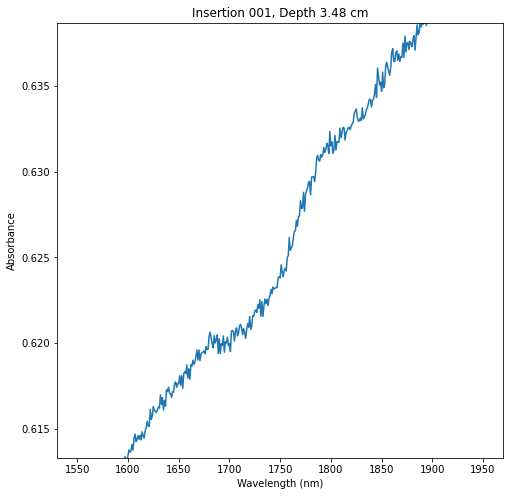

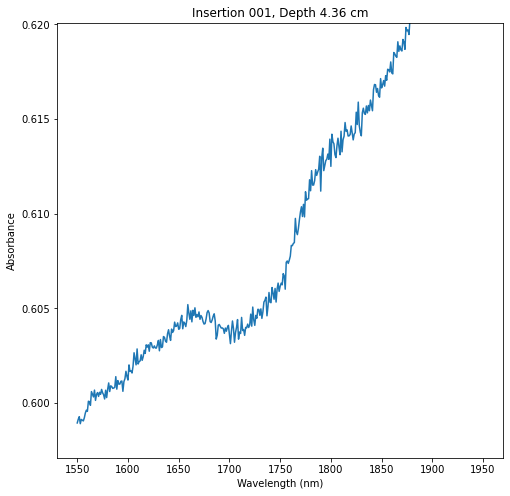

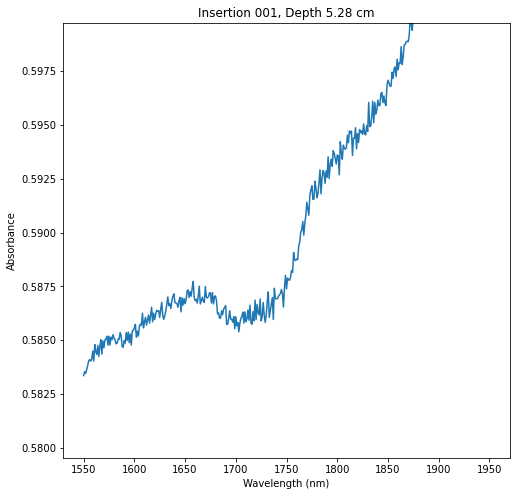

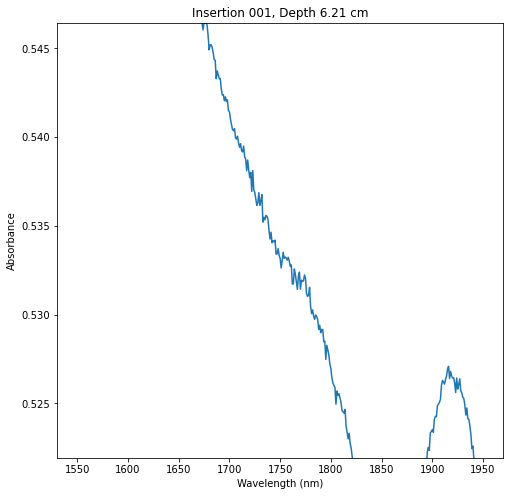

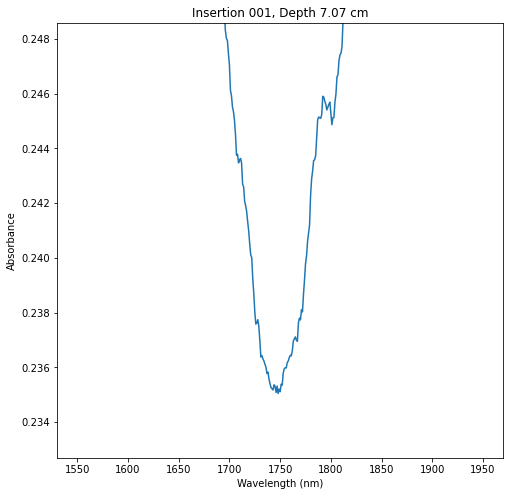

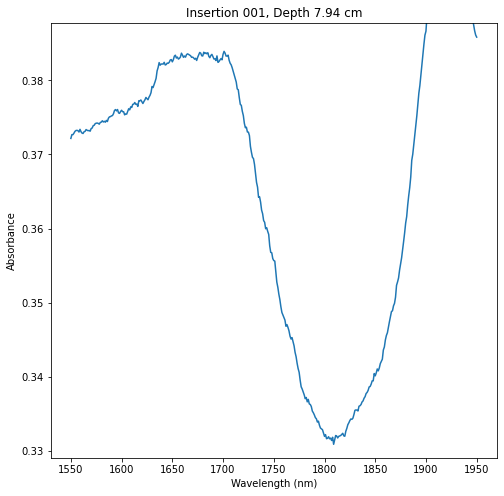

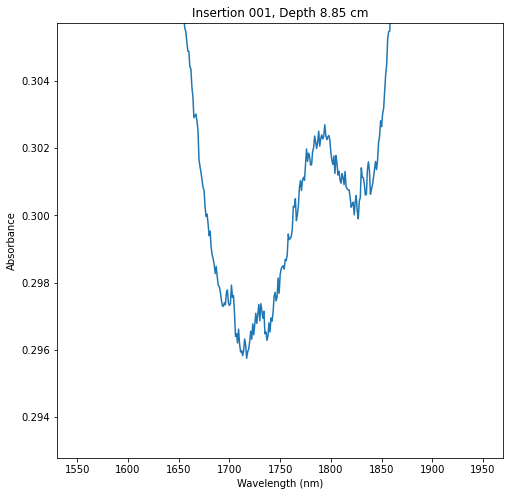

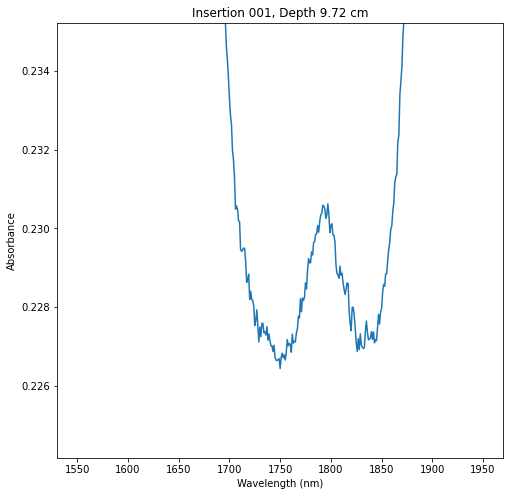

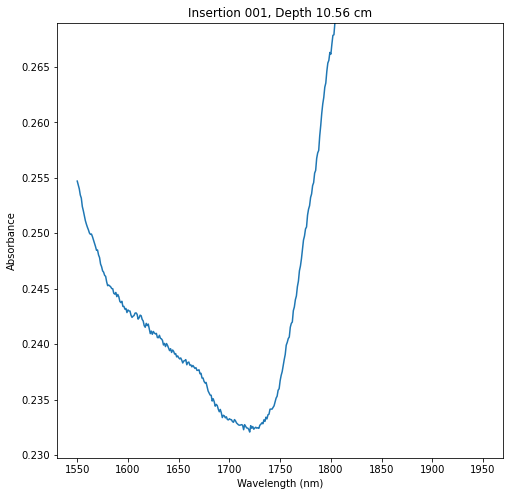

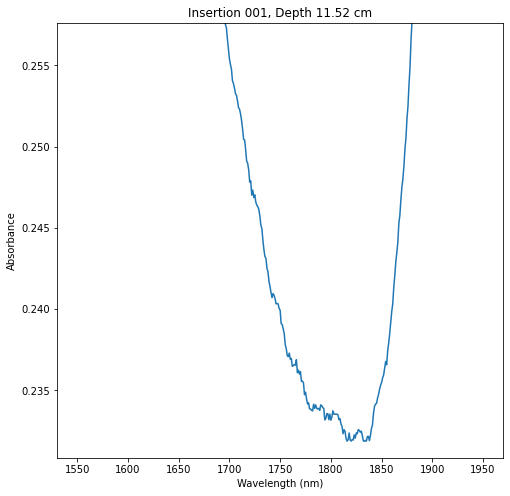

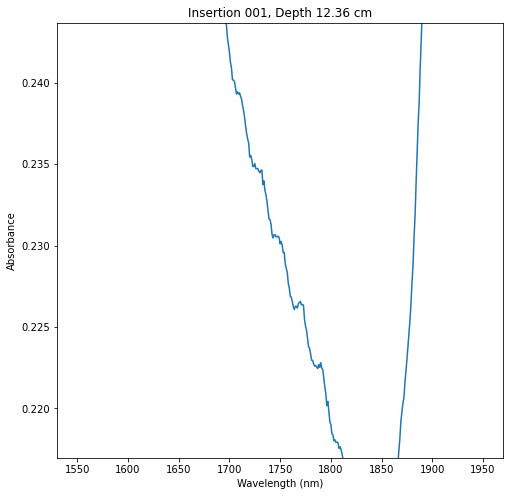

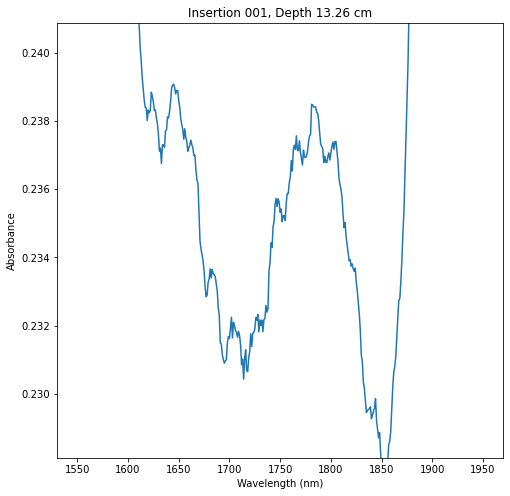

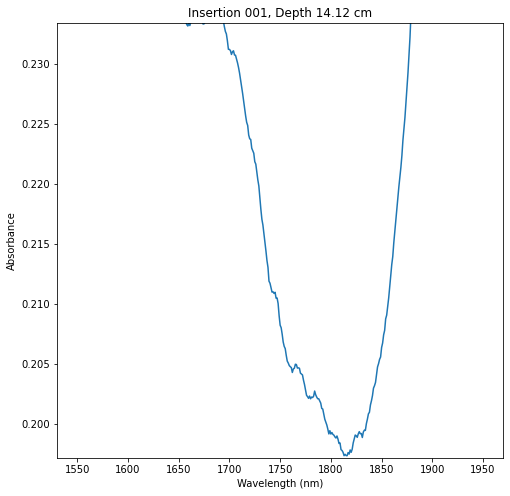

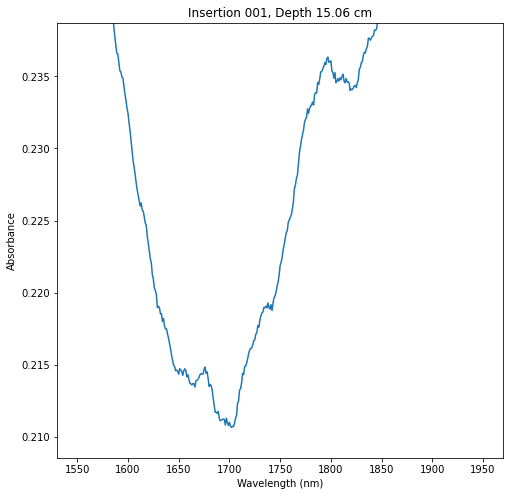

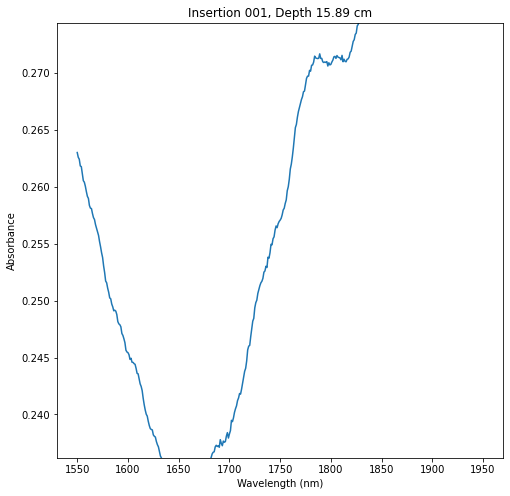

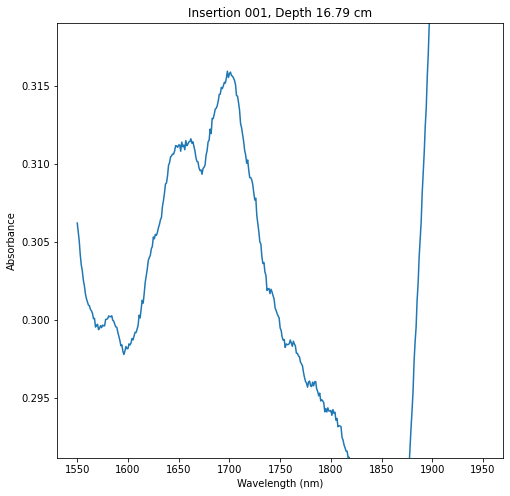

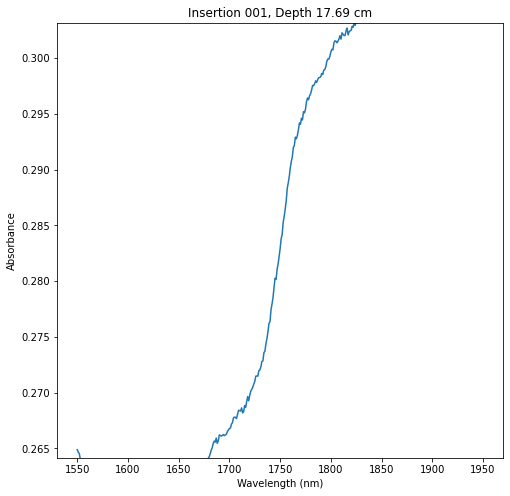

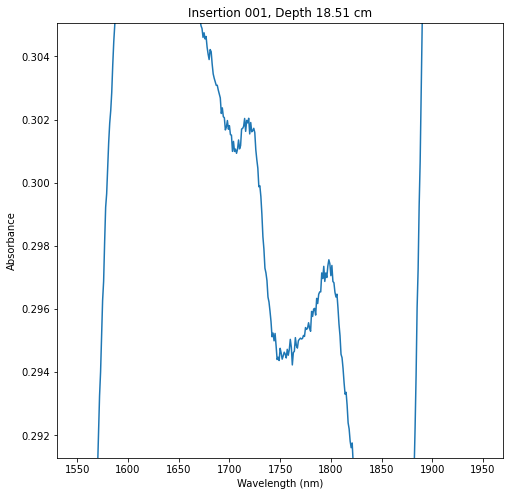

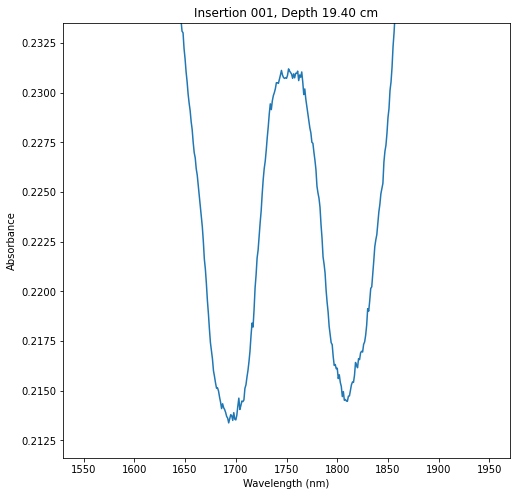

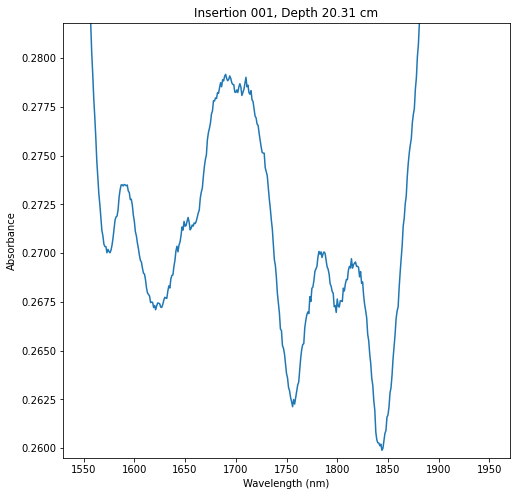

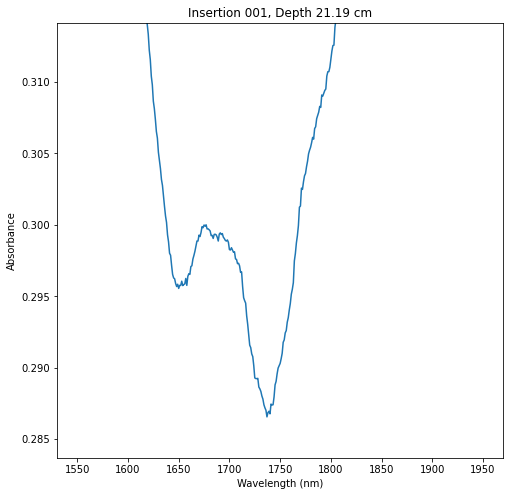

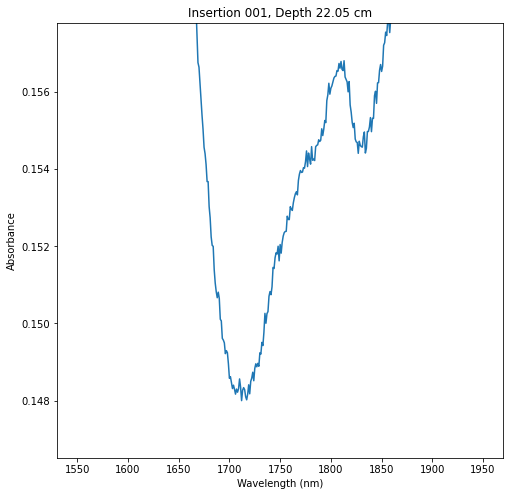

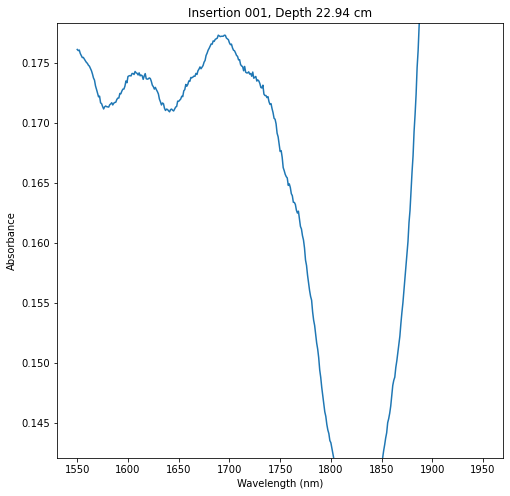

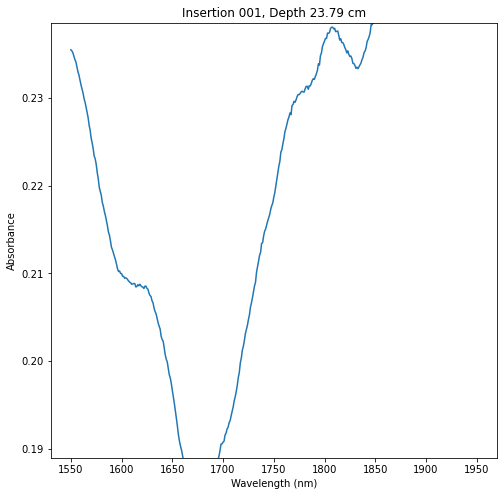

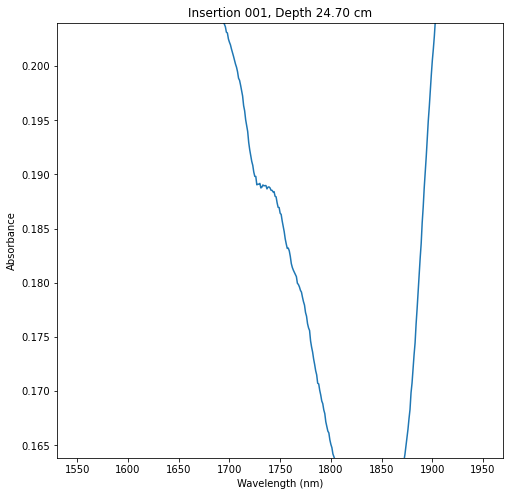

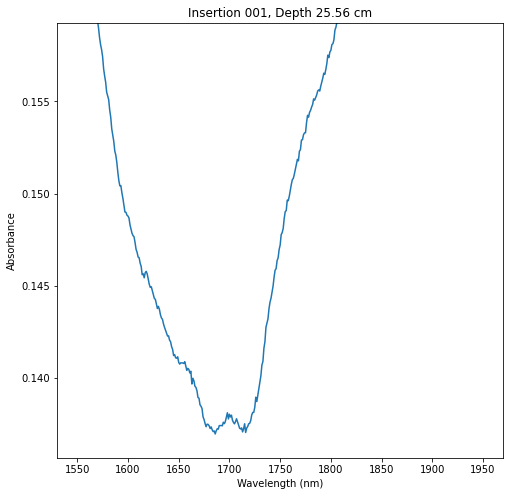

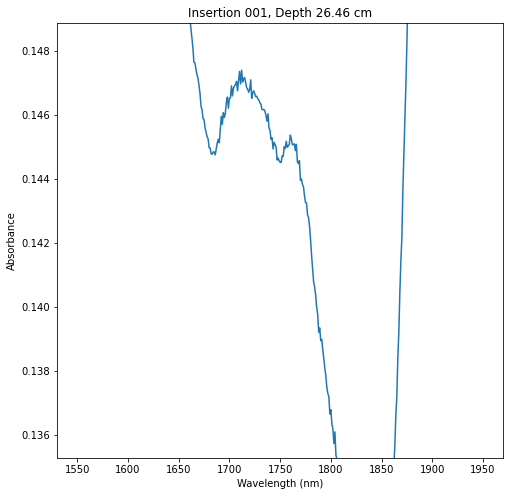

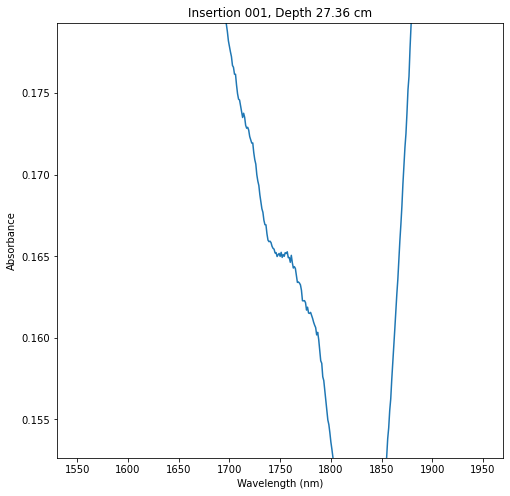

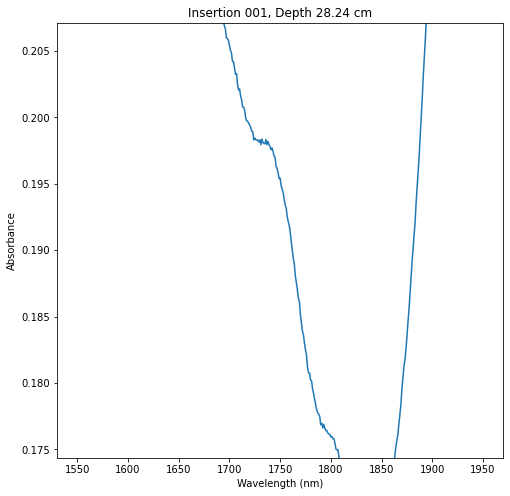

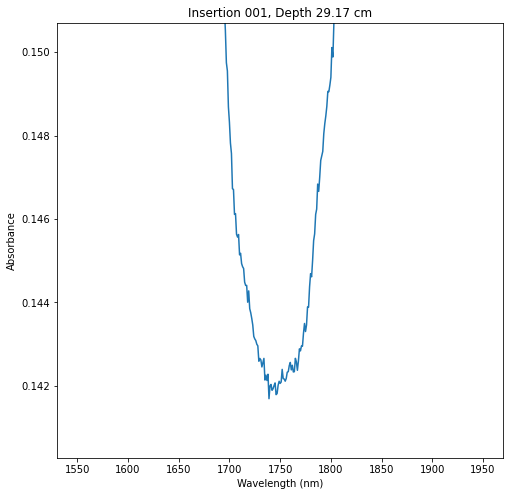

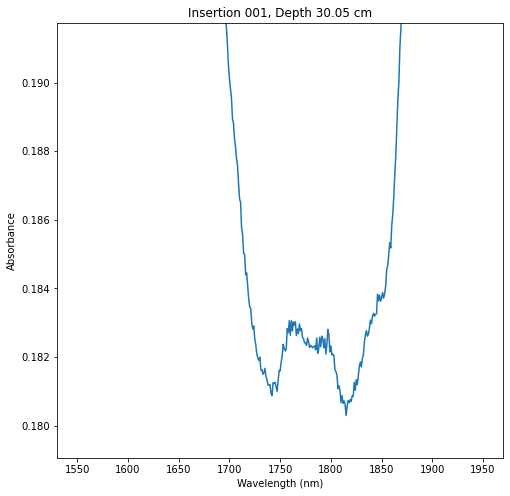

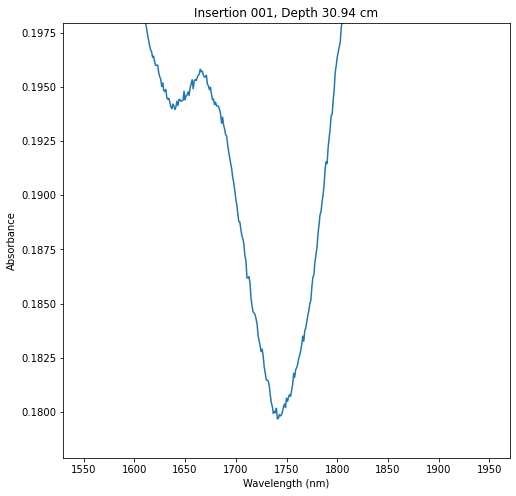

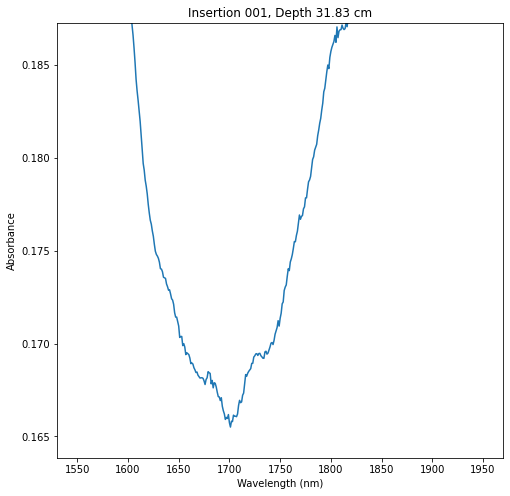

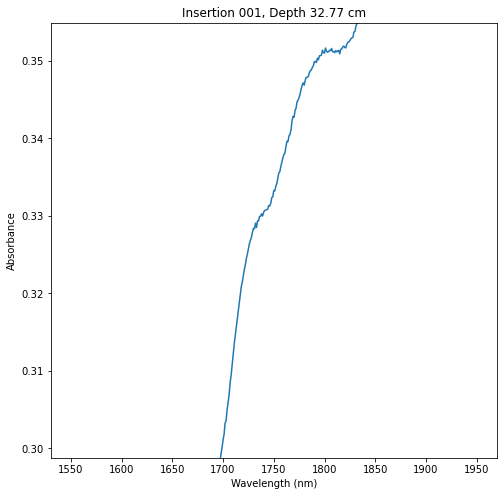

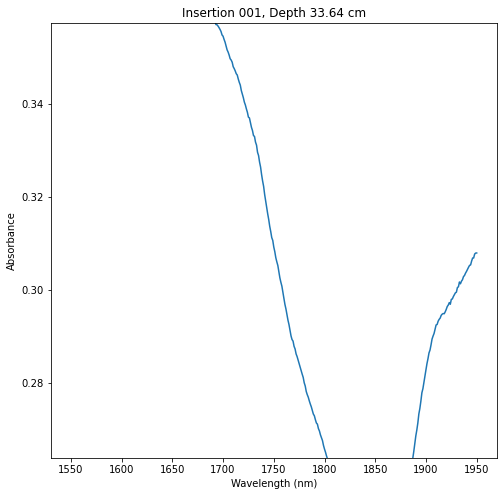

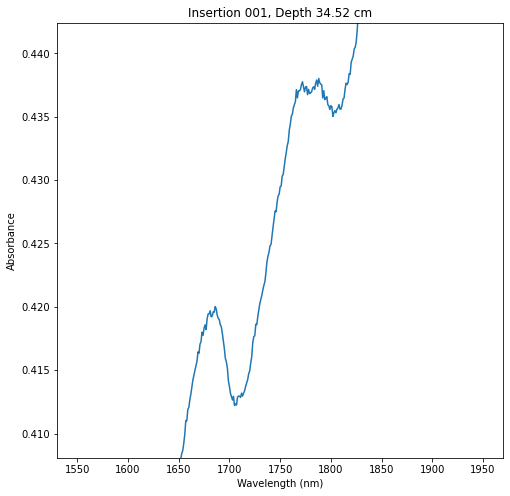

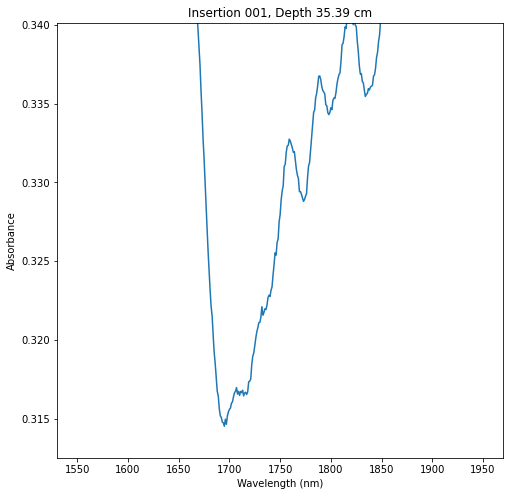

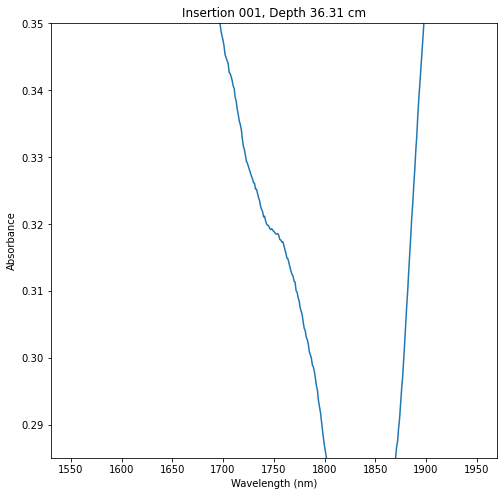

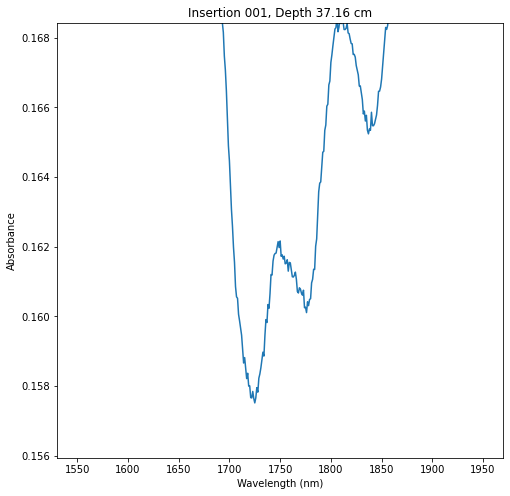

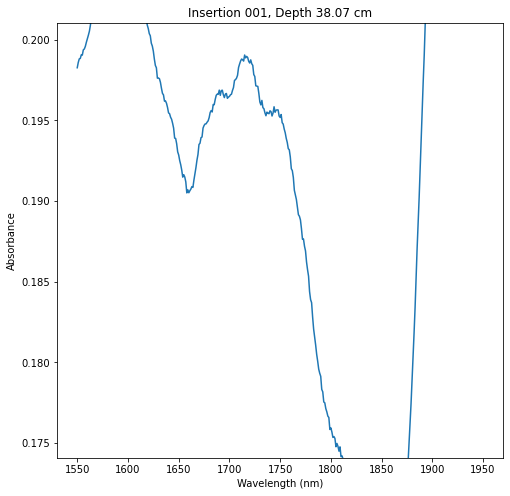

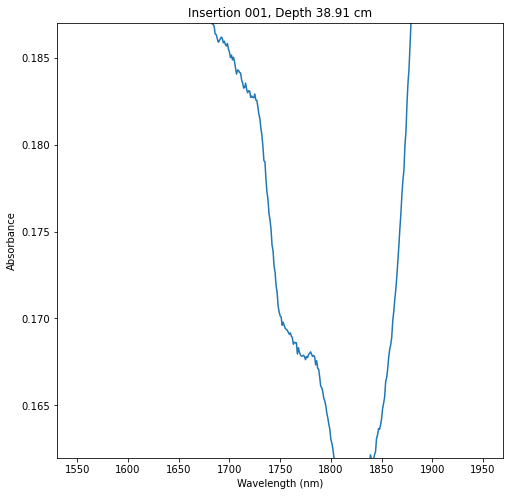

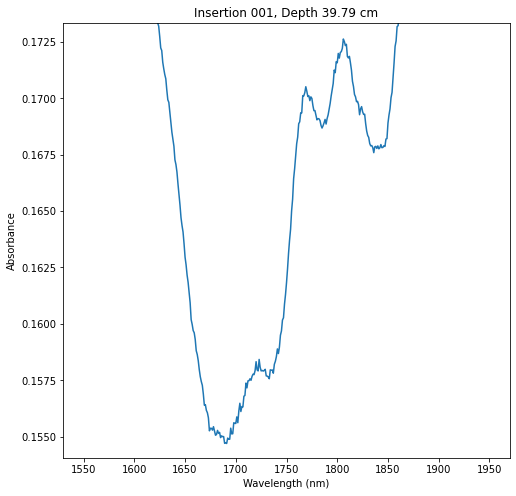

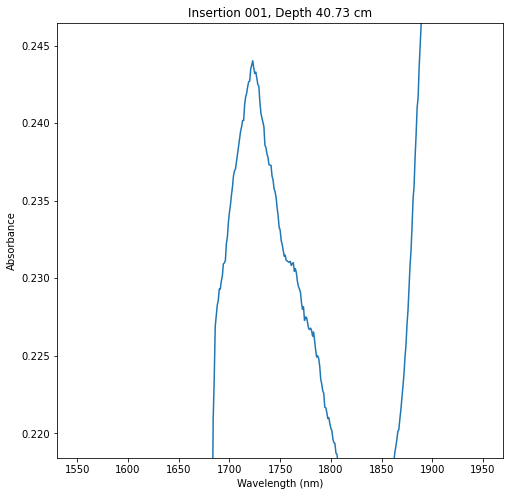

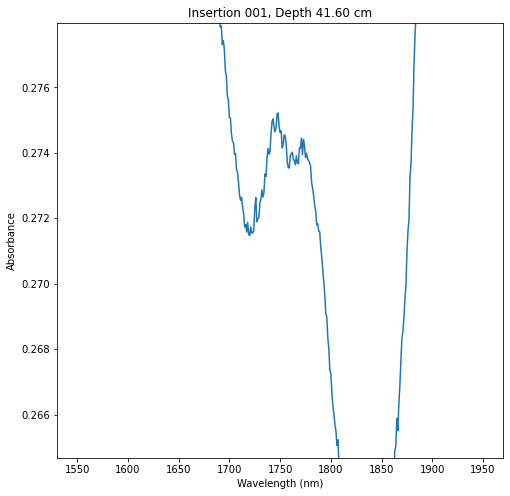

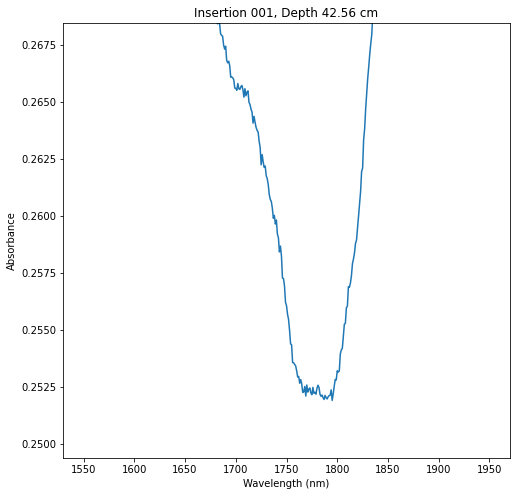

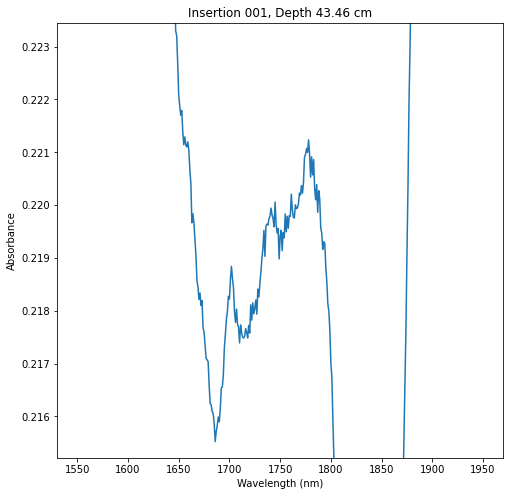

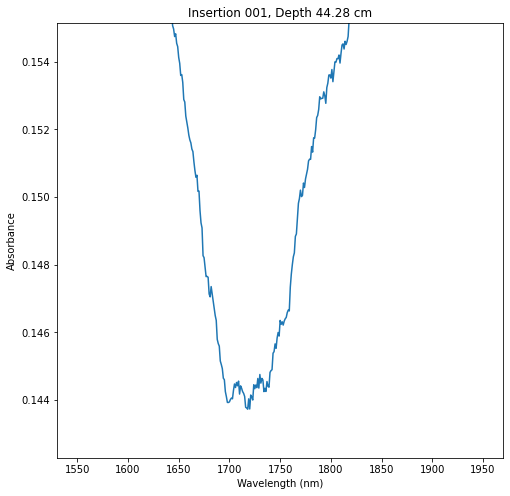

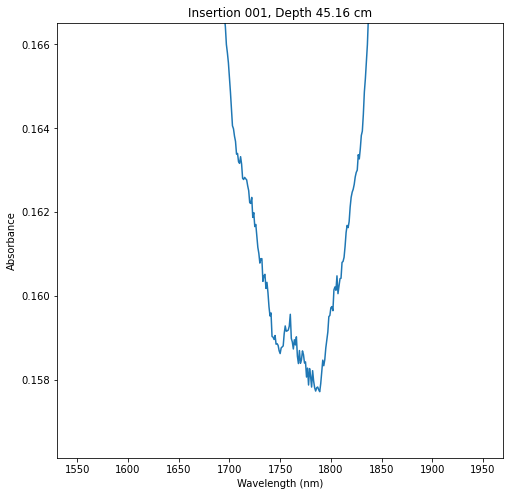

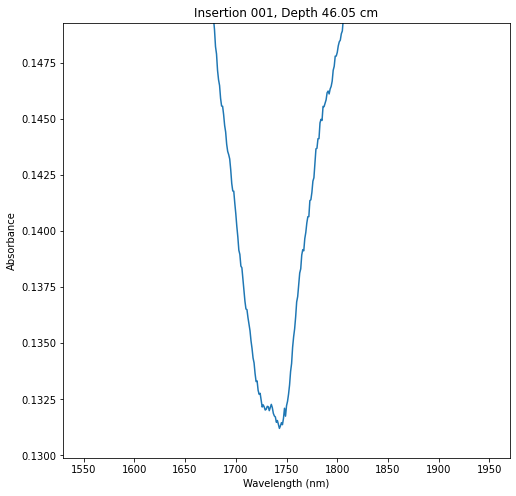

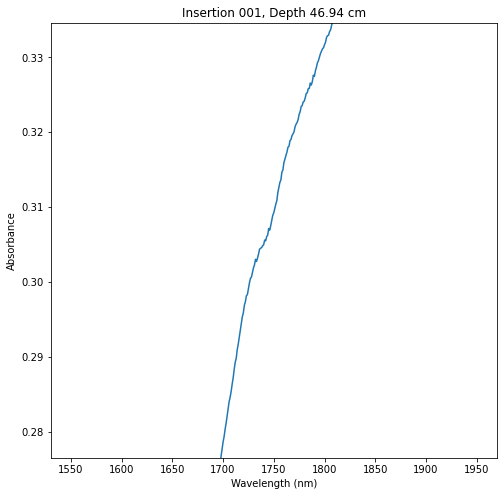

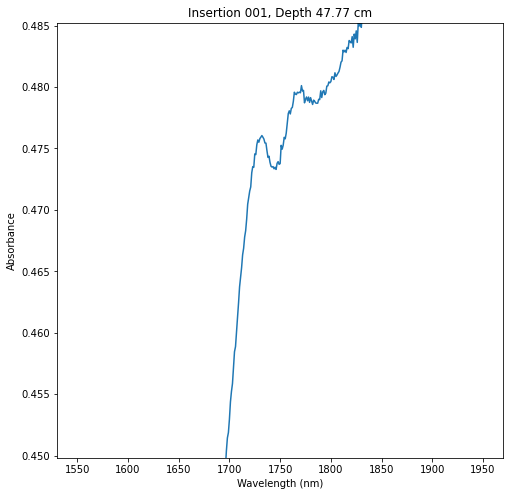

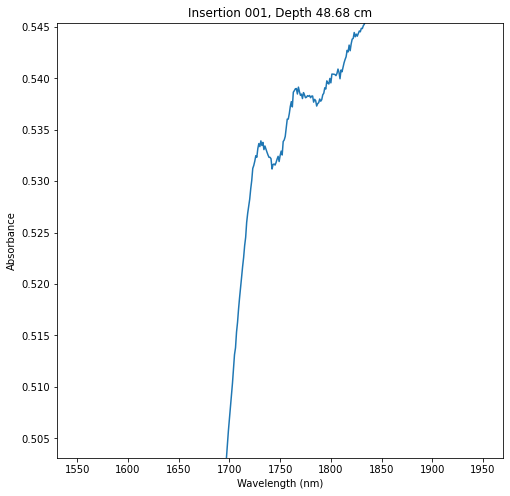

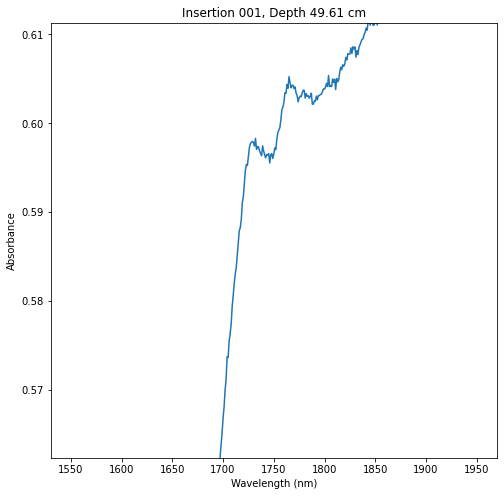

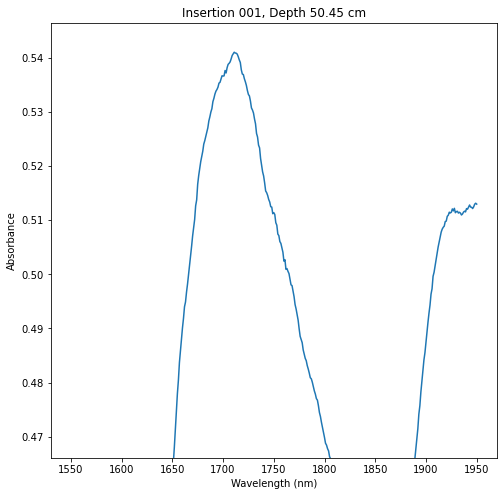

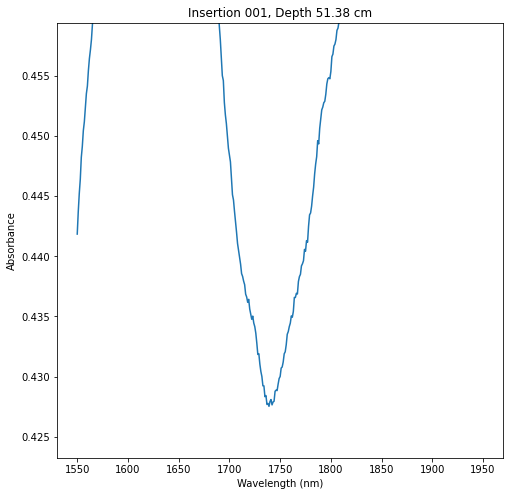

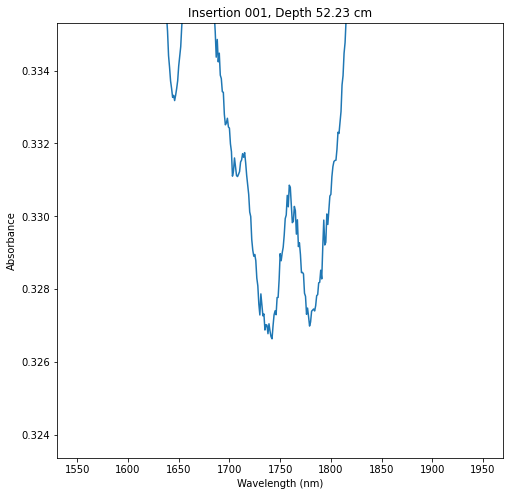

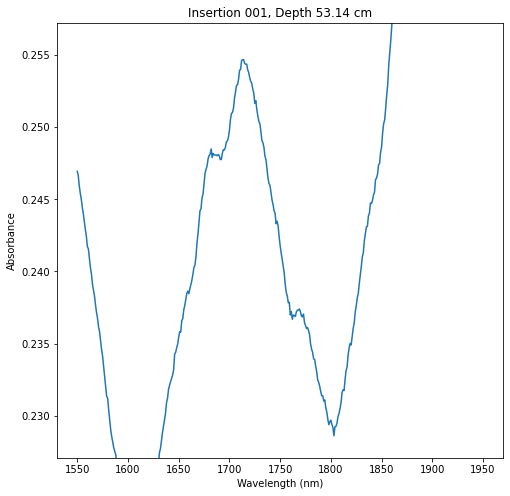

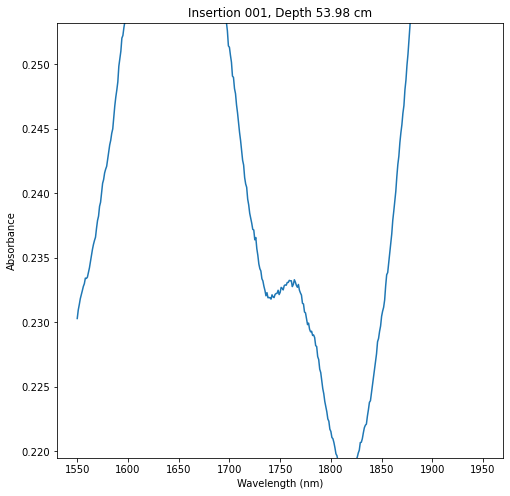

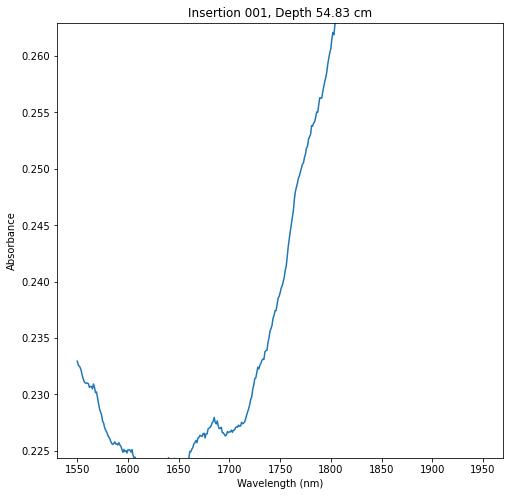

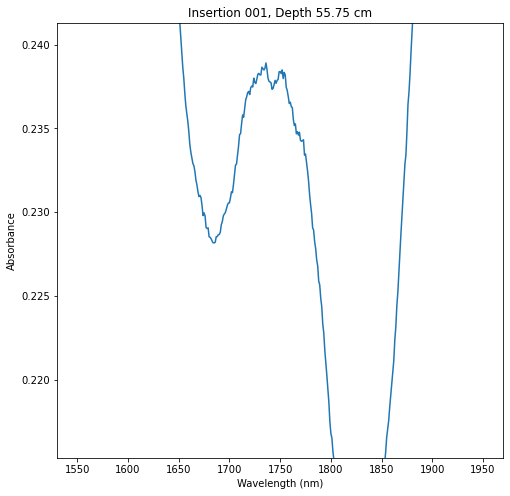

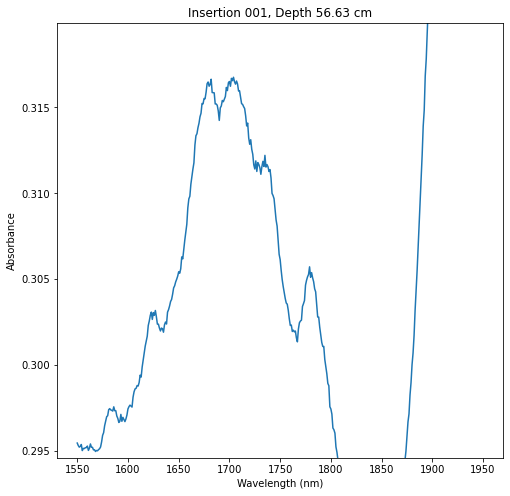

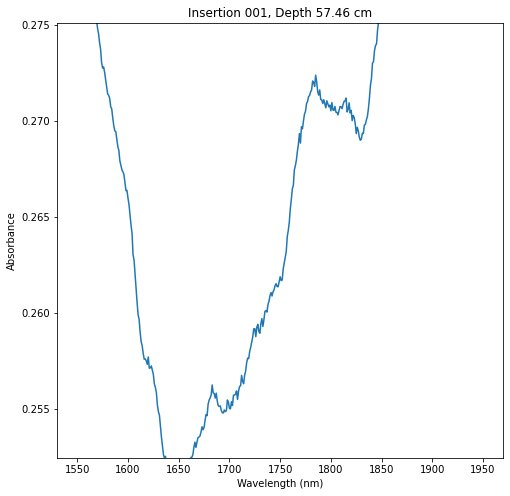

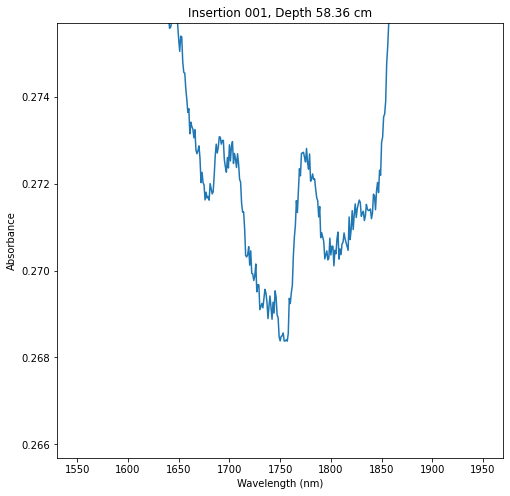

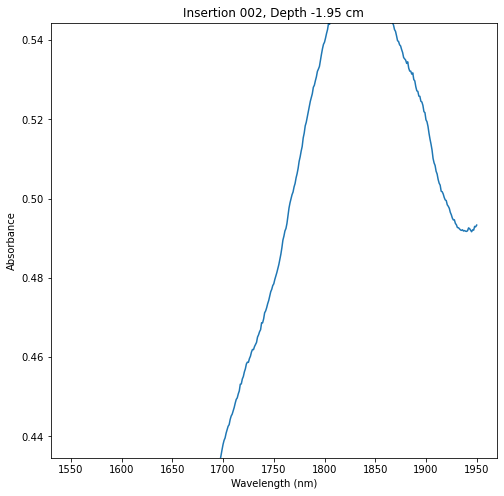

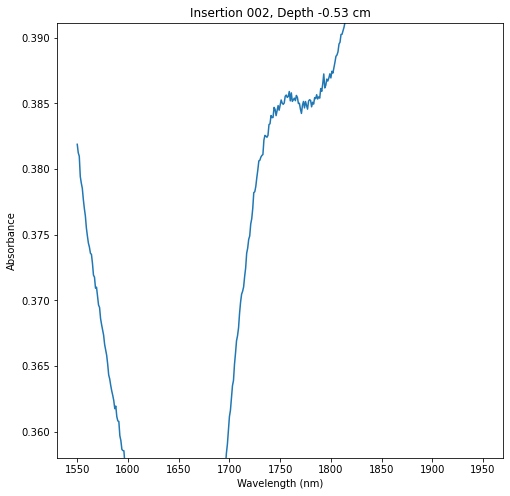

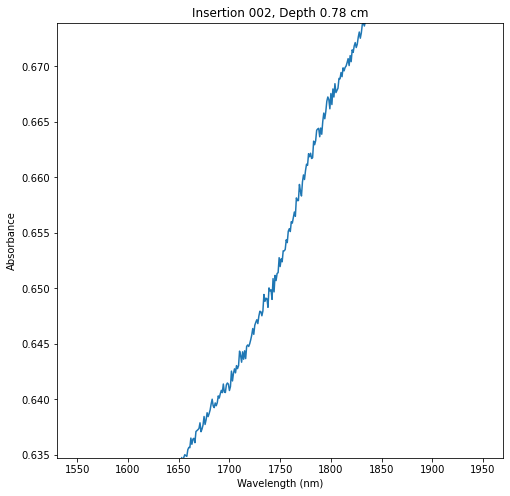

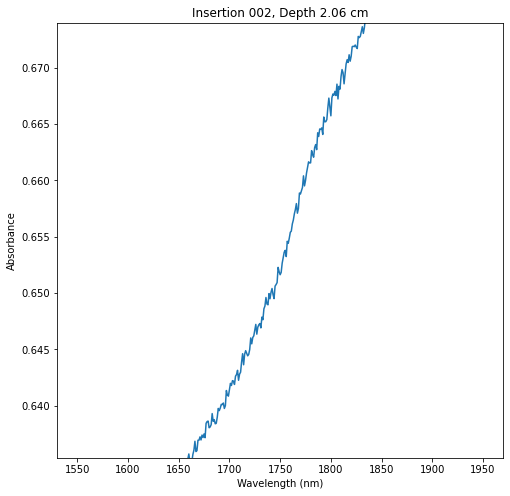

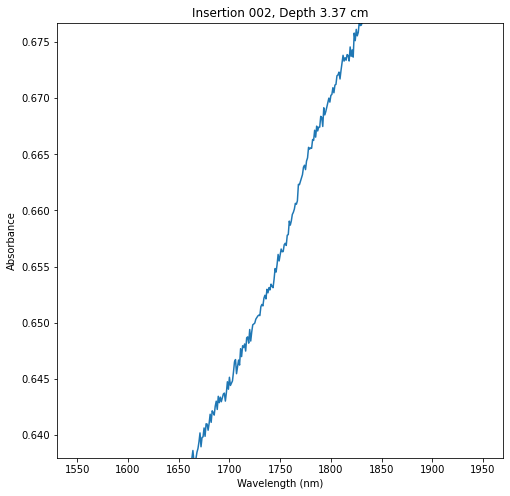

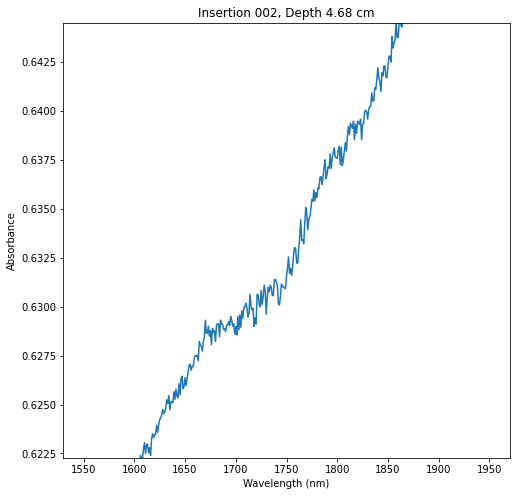

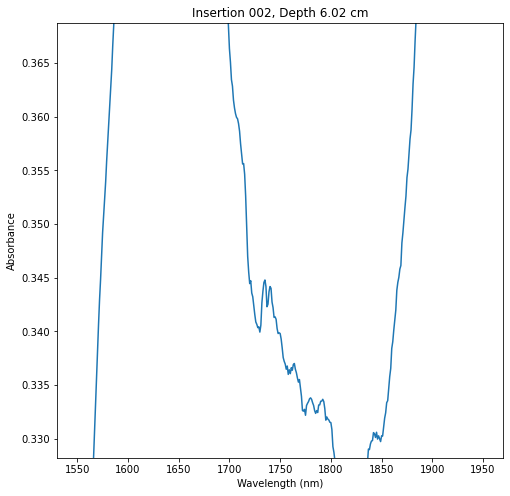

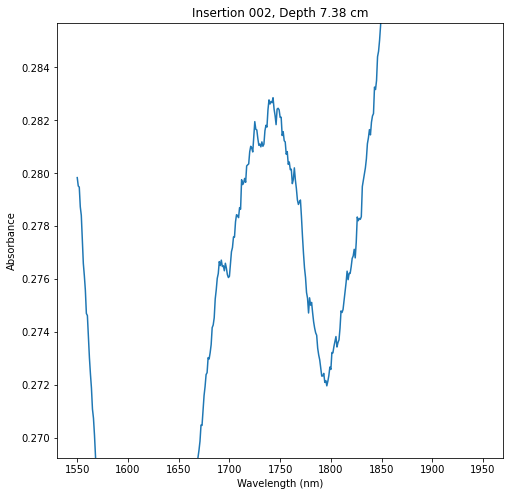

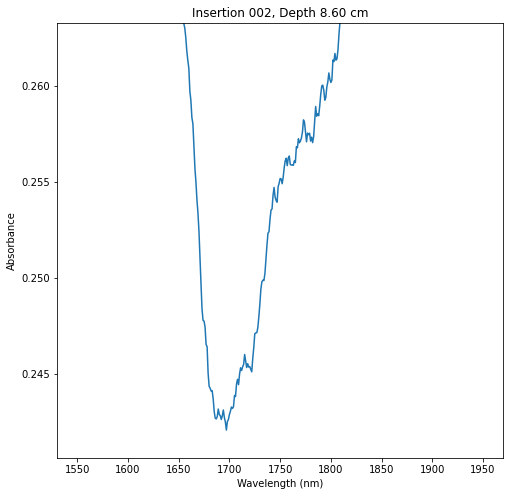

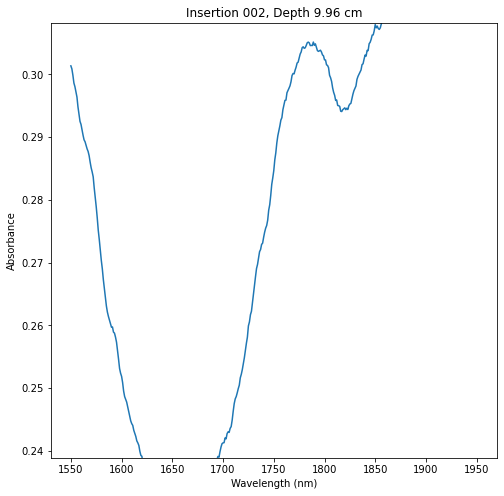

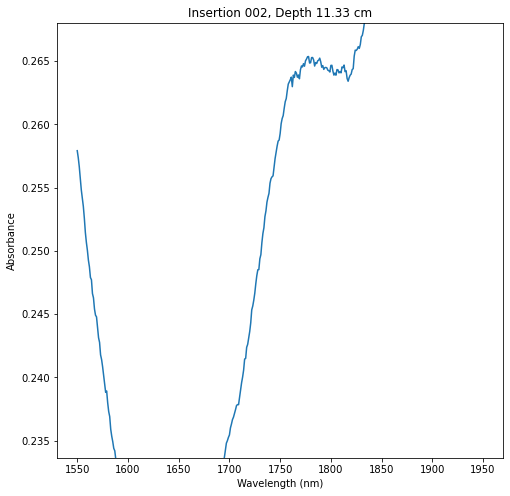

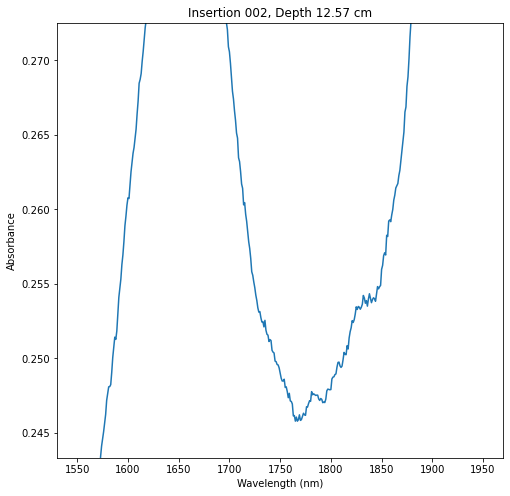

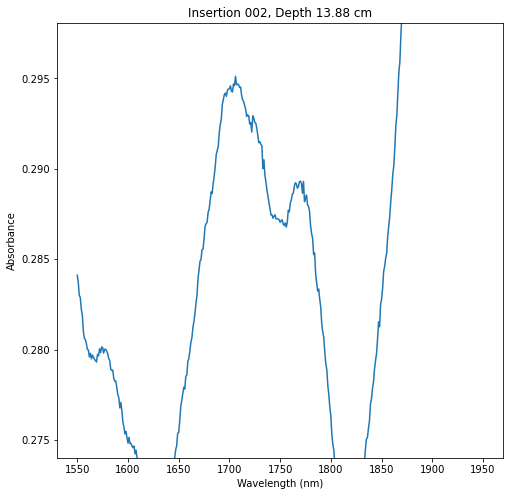

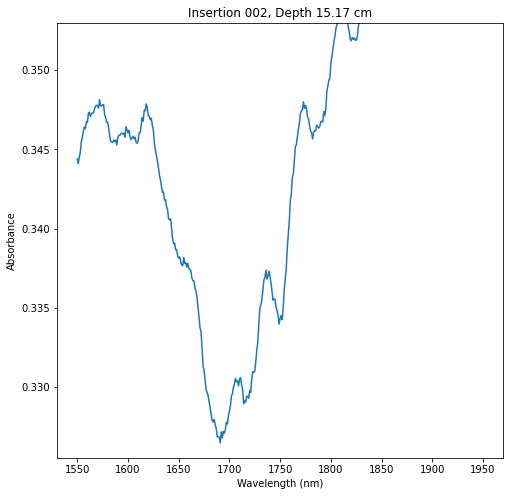

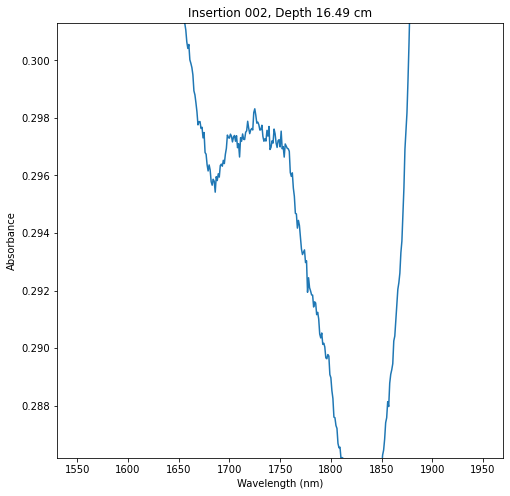

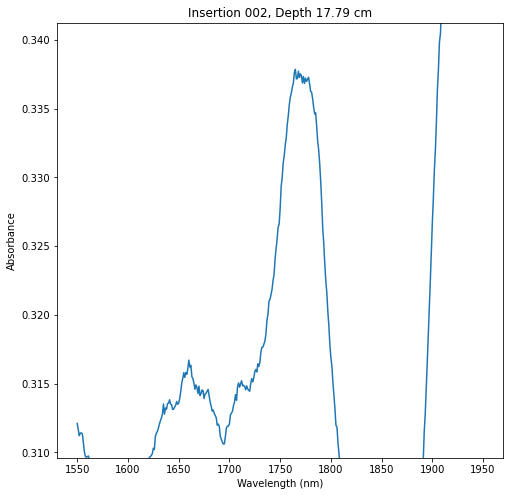

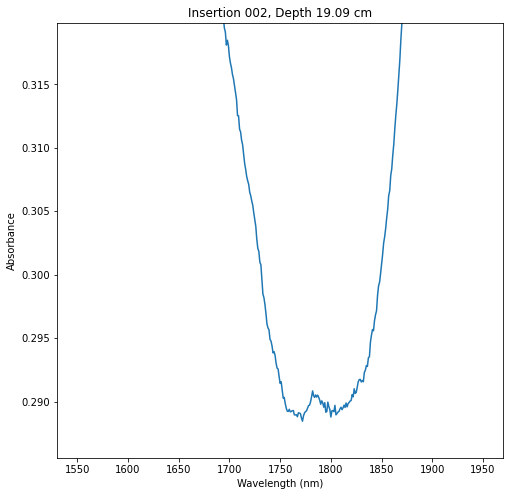

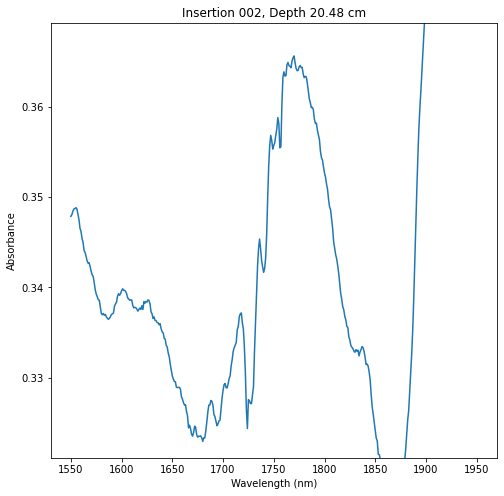

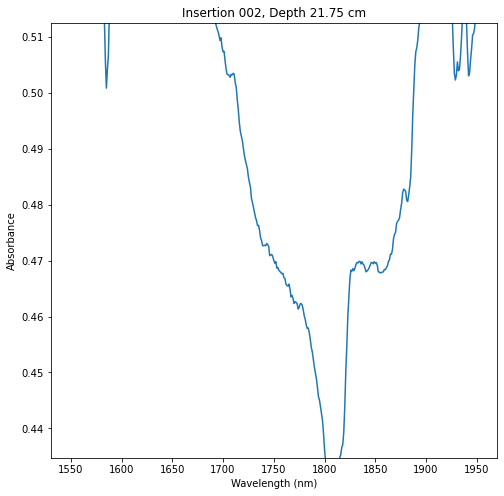

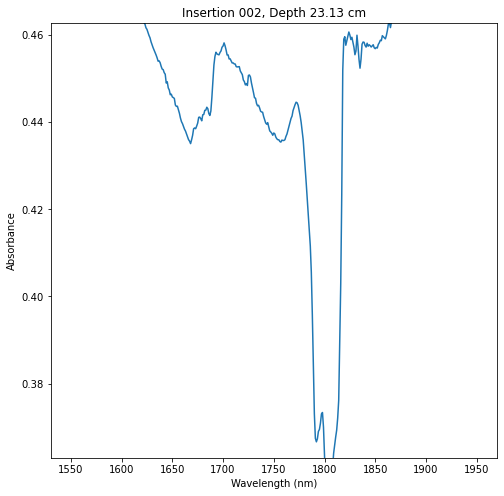

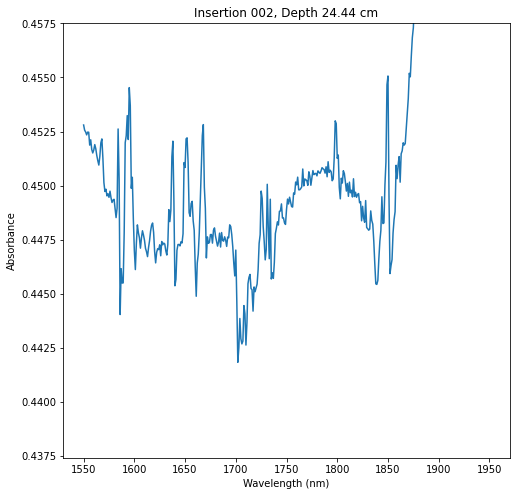

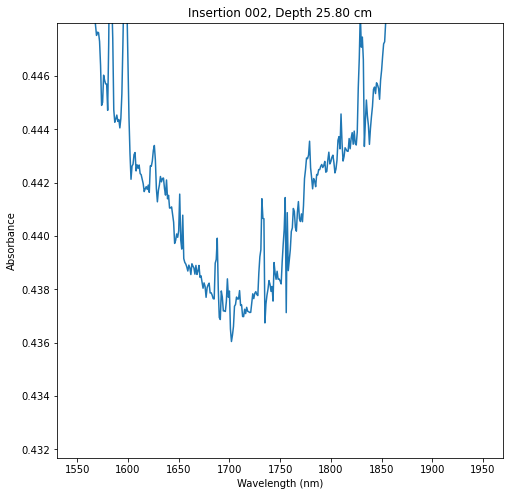

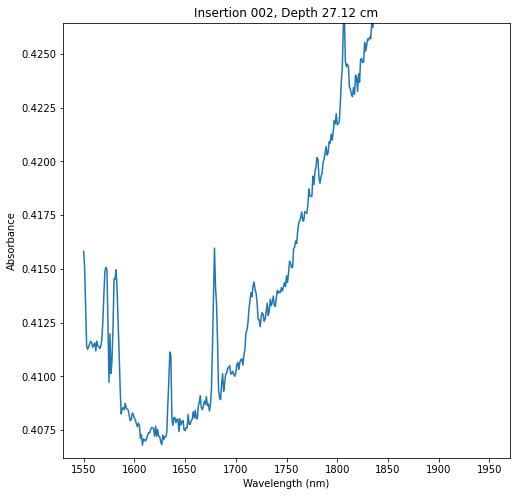

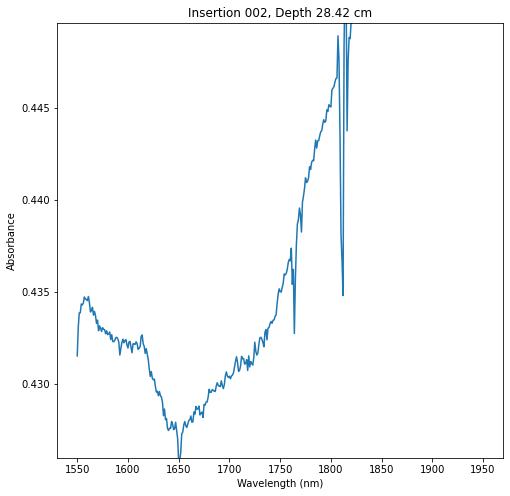

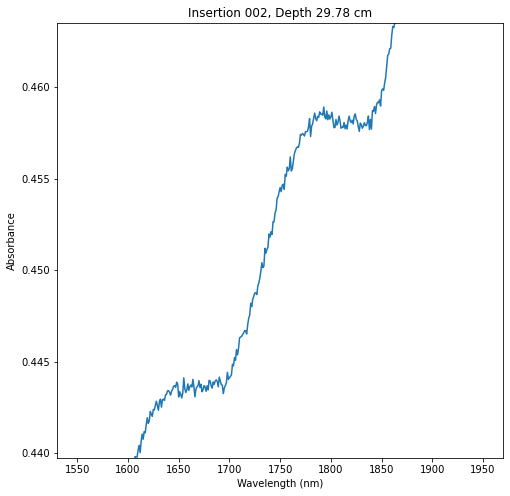

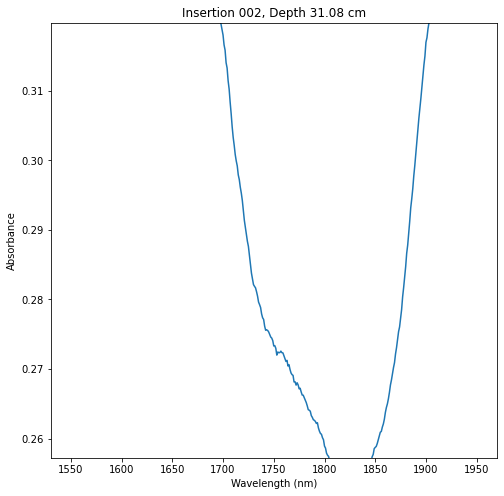

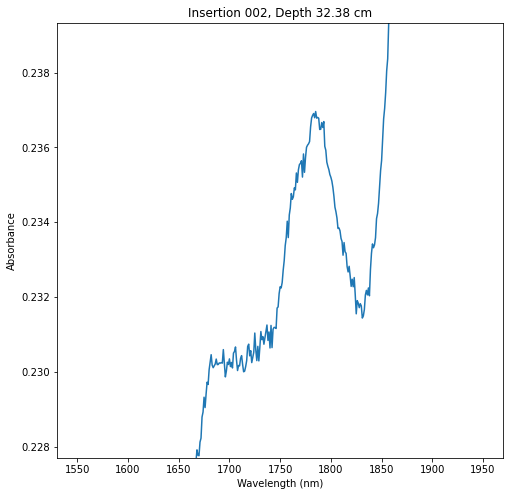

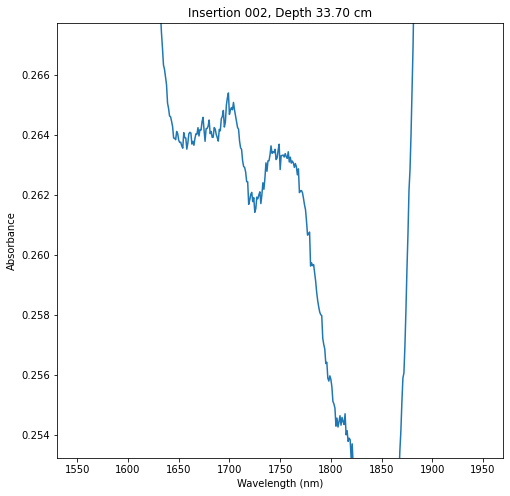

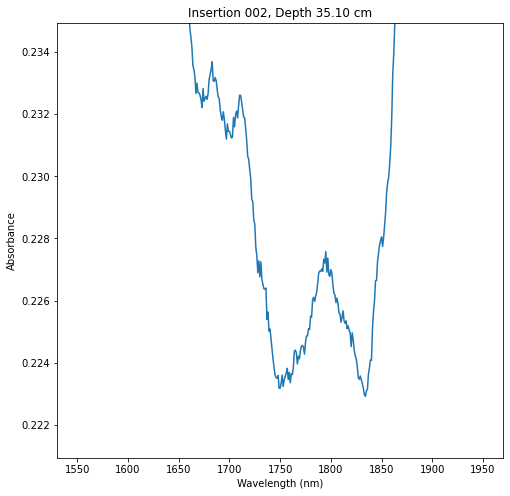

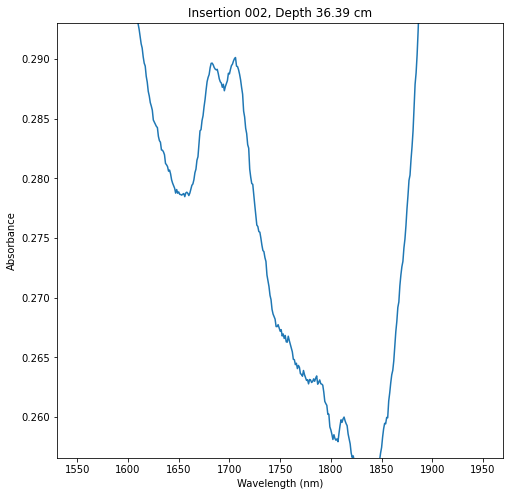

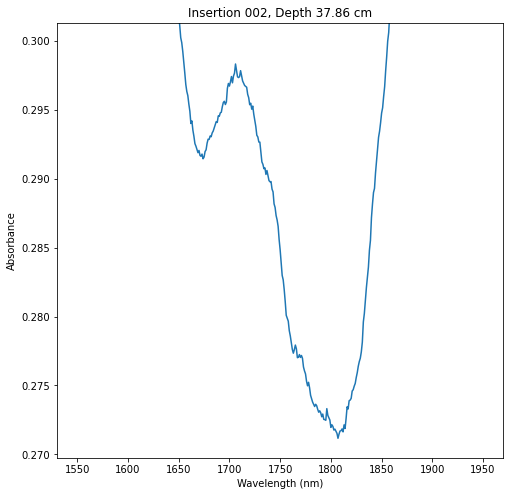

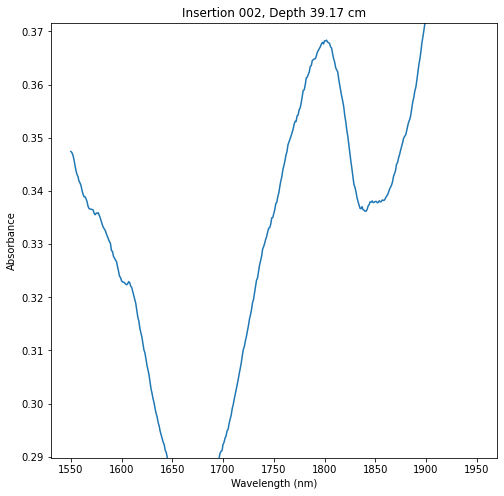

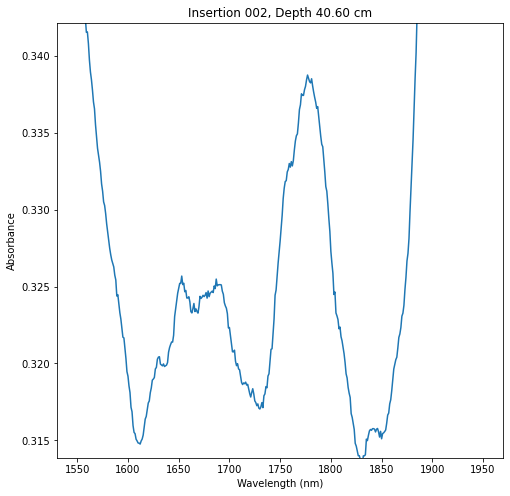

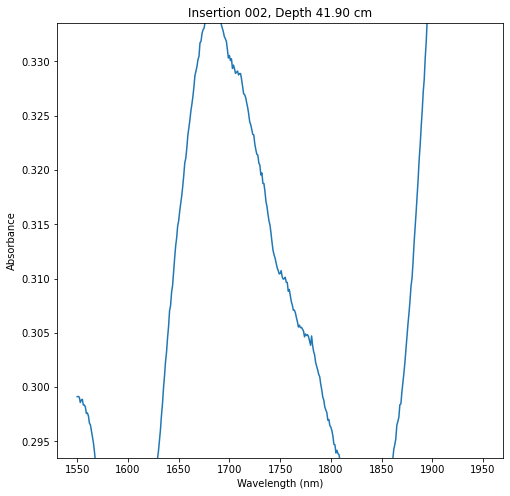

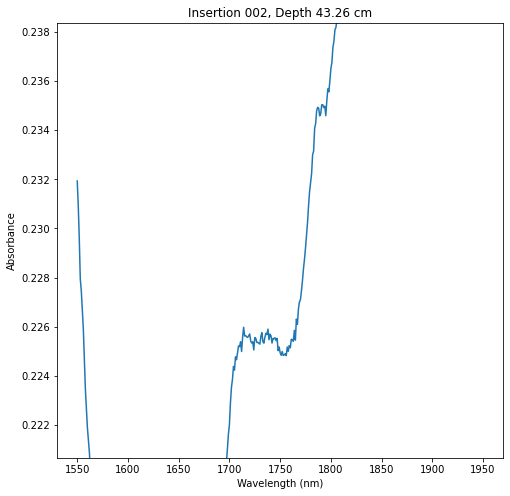

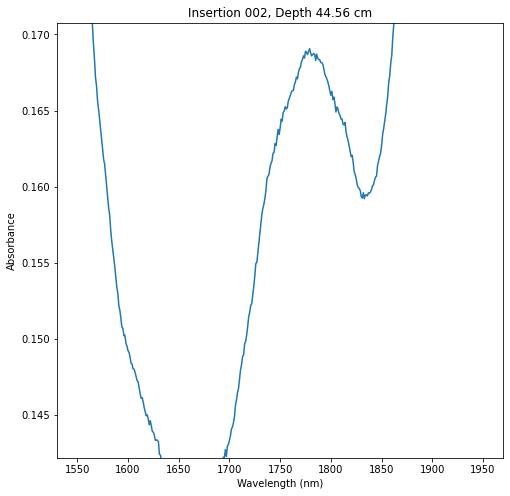

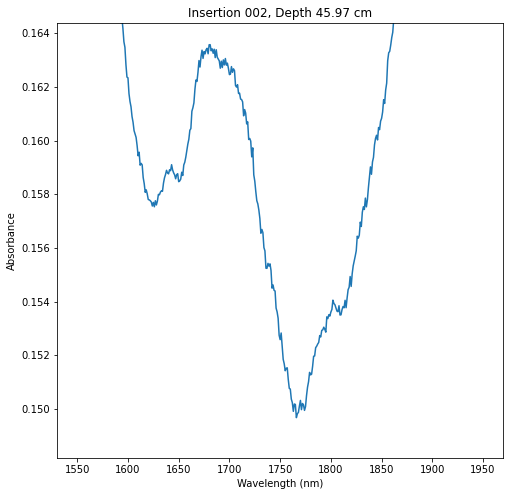

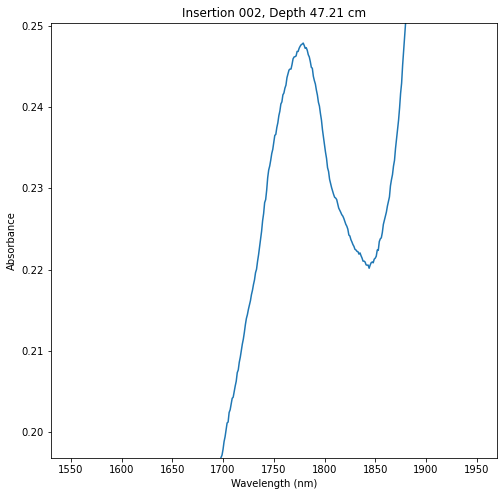

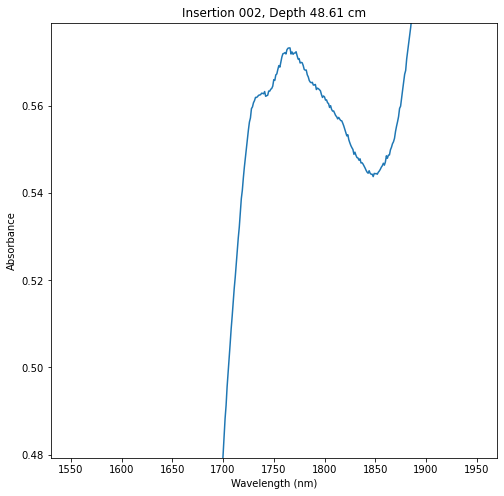

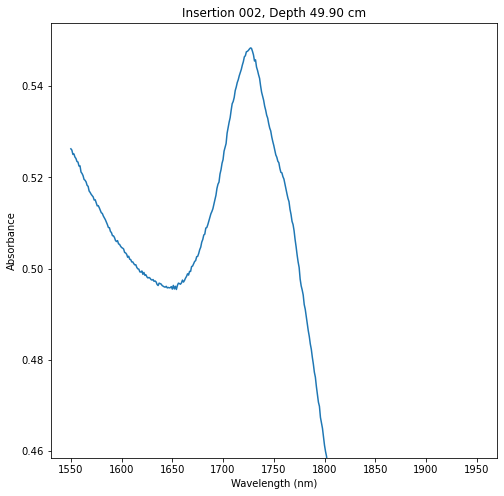

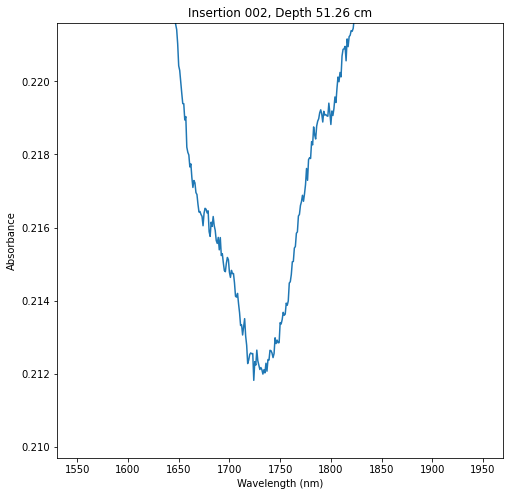

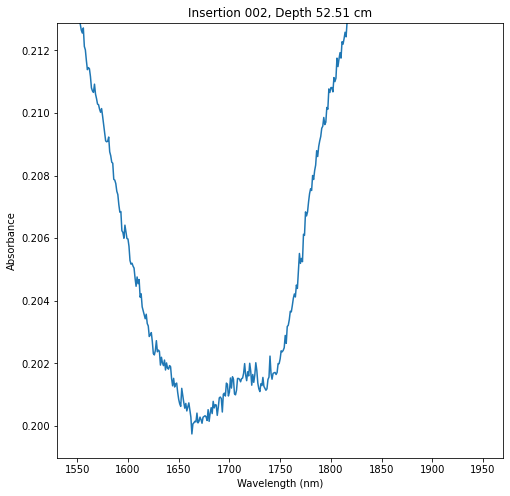

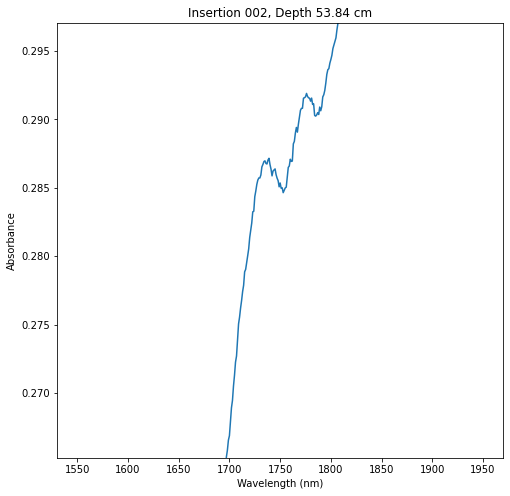

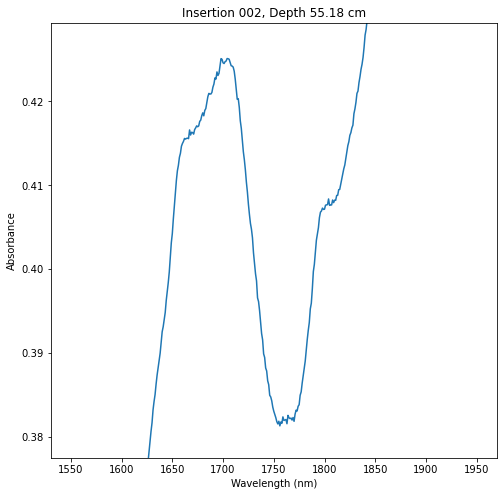

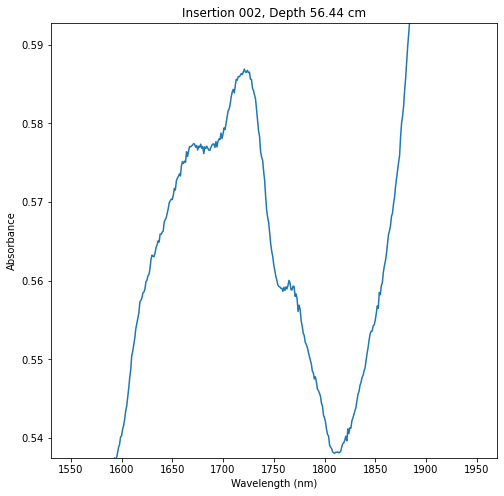

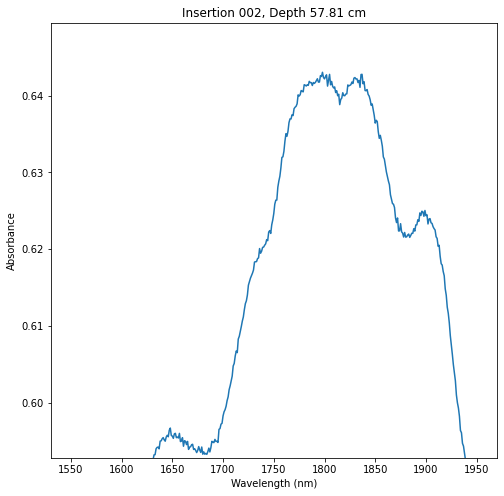

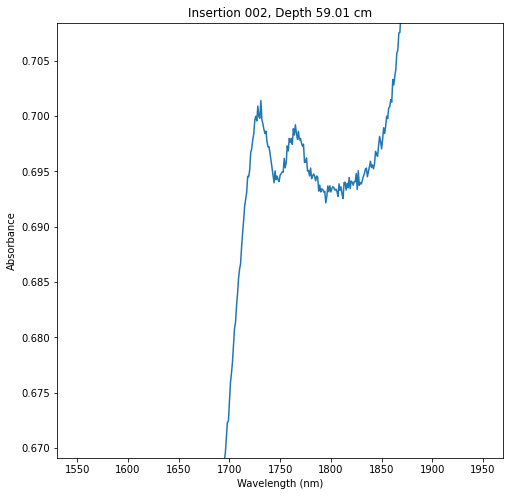

In [7]:
for i in range(len(dfs)):  
    for spectrum in range(dfs[i].shape[0]):
        absorb_spectrum = dfs[i].iloc[spectrum, :-2]
        ymin,ymax = find_zoomed_yvalues(waves, absorb_spectrum)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_ylim(ymin, ymax)
        ax.set_ylabel("Absorbance")
        ax.set_xlabel("Wavelength (nm)")
        ax.set_title(f"Insertion {(i + 1):03d}, Depth {dfs[i].iloc[spectrum, -1]:0.2f} cm")
        ax.plot(waves, absorb_spectrum)
        plt.show()

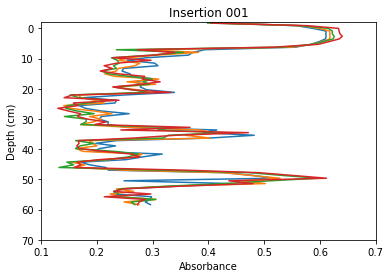

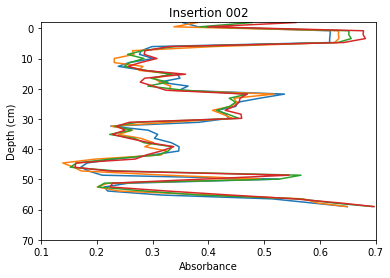

In [11]:
for i in range(len(dfs)):
    fig, ax = plt.subplots()
    ax.set_ylim(70.0, -2.0)
    ax.set_xlim(0.1, 0.7)
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel("Absorbance")
    ax.set_title(f"Insertion {(i + 1):03d}")
    abs1550 = dfs[i].loc[:, 1550.0]
    abs1650 = dfs[i].loc[:, 1650.0]
    abs1750 = dfs[i].loc[:, 1750.0]
    abs1850 = dfs[i].loc[:, 1850.0]
    depth = dfs[i].loc[:, "depth"]
    ax.plot(abs1550, depth)
    ax.plot(abs1650, depth)
    ax.plot(abs1750, depth)
    ax.plot(abs1850, depth)

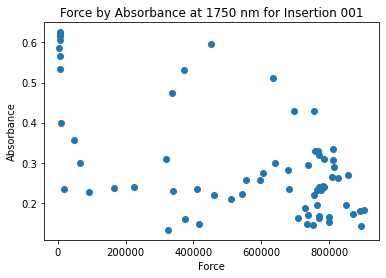

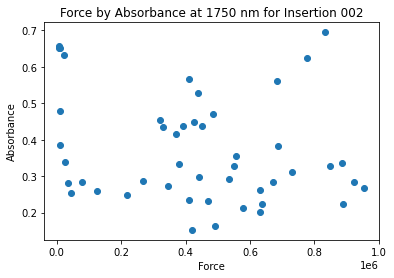

In [15]:
for i in range(len(dfs)):
    fig, ax = plt.subplots()
    ax.set_title(f"Force by Absorbance at 1750 nm for Insertion {i + 1:03d}")
    ax.set_ylabel("Absorbance")
    ax.set_xlabel("Force")
    force = dfs[i].loc[:, 'force']
    abs1750 = dfs[i].loc[:, 1750.0]    
    ax.plot(force, abs1750, 'o')

In [17]:
dsets = create_list_of_datasets_in_h5file(h5_file)

In [18]:
dsets

['session002/cal001/ins001/derived/absorbance_depth',
 'session002/cal001/ins001/derived/absorbance_depth_timestamps',
 'session002/cal001/ins001/derived/depth_increment_data',
 'session002/cal001/ins001/derived/force_depth',
 'session002/cal001/ins001/derived/force_depth_timestamps',
 'session002/cal001/ins001/encoder/depths',
 'session002/cal001/ins001/encoder/timestamps',
 'session002/cal001/ins001/load_cell/forces',
 'session002/cal001/ins001/load_cell/timestamps',
 'session002/cal001/ins001/spectrometer1/derived/absorbances',
 'session002/cal001/ins001/spectrometer1/spectra',
 'session002/cal001/ins001/spectrometer1/timestamps',
 'session002/cal001/ins002/derived/absorbance_depth',
 'session002/cal001/ins002/derived/absorbance_depth_timestamps',
 'session002/cal001/ins002/derived/depth_increment_data',
 'session002/cal001/ins002/derived/force_depth',
 'session002/cal001/ins002/derived/force_depth_timestamps',
 'session002/cal001/ins002/encoder/depths',
 'session002/cal001/ins002/e

In [21]:
ins1_raw = h5_file['session008/cal001/ins001/spectrometer1/spectra'][:]

In [22]:
ins1_raw

array([[ 8577.5       ,  8582.        ,  8584.5       , ...,
         5972.39990234,  5978.29980469,  5985.89990234],
       [ 6435.        ,  6435.        ,  6429.        , ...,
         4162.20019531,  4173.39990234,  4179.        ],
       [ 6030.79980469,  6025.10009766,  6028.10009766, ...,
         3824.80004883,  3832.60009766,  3833.69995117],
       ...,
       [11579.        , 11588.40039062, 11594.70019531, ...,
         7481.5       ,  7499.29980469,  7519.70019531],
       [11803.59960938, 11830.09960938, 11850.59960938, ...,
         6981.70019531,  6996.39990234,  7013.39990234],
       [11560.        , 11572.29980469, 11586.20019531, ...,
         7259.60009766,  7272.60009766,  7287.60009766]])

In [ ]:
inserts = create_list_of_insertions_in_node(h5_file, "session008")
waves = h5_file['session008/cal001'].attrs['spec1_wavelengths_vector'][:]
cols = waves.tolist()
cols.append('force')
cols.append('depth')
dfs = []
for i in range(len(inserts)):
    df_name = f"df{i+1}"
    dfs.append(df_name)
absorb_str = 'derived/absorbance_depth'
for i in range(len(inserts)):
    dfs[i] = pd.DataFrame(data = h5_file[f'session008/{inserts[i]}/{absorb_str}'][:], columns=cols)

In [25]:
raw_dfs = []
for i in range(len(inserts)):
    df_name = f"df{i+1}"
    raw_dfs.append(df_name)
raw_str = 'spectrometer1/spectra'
for i in range(len(inserts)):
    raw_dfs[i] = pd.DataFrame(data = h5_file[f'session008/{inserts[i]}/{raw_str}'][:], columns=waves)

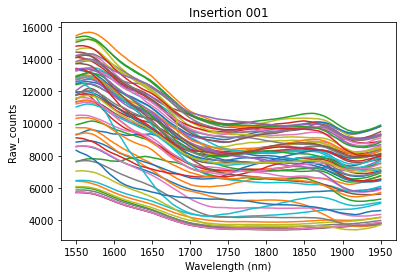

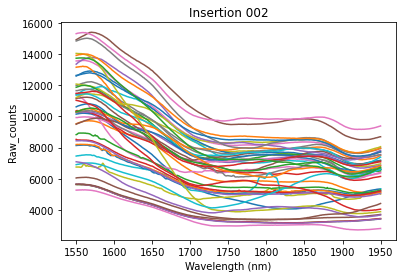

In [27]:
for i in range(len(raw_dfs)):
    fig, ax = plt.subplots()
    
    ax.set_ylabel("Raw_counts")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_title(f"Insertion {(i + 1):03d}")
    for spectrum in range(raw_dfs[i].shape[0]):
        ax.plot(waves, raw_dfs[i].iloc[spectrum, :])
    plt.show()

In [28]:
raw_dfs[0]

1550.0        1551.0        1552.0        1553.0        1554.0  \
0    8577.500000   8582.000000   8584.500000   8590.099609   8587.200195   
1    6435.000000   6435.000000   6429.000000   6419.700195   6415.600098   
2    6030.799805   6025.100098   6028.100098   6029.799805   6029.500000   
3    5724.899902   5725.600098   5725.399902   5726.299805   5722.799805   
4    5729.500000   5733.100098   5732.399902   5728.600098   5735.100098   
..           ...           ...           ...           ...           ...   
64  13333.400391  13349.700195  13357.599609  13363.099609  13376.099609   
65  11504.000000  11534.299805  11554.700195  11575.200195  11607.799805   
66  11579.000000  11588.400391  11594.700195  11594.500000  11595.200195   
67  11803.599609  11830.099609  11850.599609  11887.200195  11906.799805   
68  11560.000000  11572.299805  11586.200195  11610.599609  11622.599609   

          1555.0        1556.0        1557.0        1558.0        1559.0  ...  \
0    8591.000000   8586.900391   8594.400391   8587.500000   8595.000000  ...   
1    6411.100098   6405.299805   6410.500000   6400.899902   6399.399902  ...   
2    6026.700195   6029.399902   6027.100098   6025.299805   6020.500000  ...   
3    5722.700195   5727.799805   5721.899902   5714.500000   5713.399902  ...   
4    5730.299805   5725.600098   5728.100098   5722.200195   5726.500000  ...   
..           ...           ...           ...           ...           ...  ...   
64  13391.200195  13402.500000  13409.400391  13412.599609  13411.599609  ...   
65  11622.799805  11649.099609  11665.299805  11683.900391  11695.900391  ...   
66  11606.700195  11604.799805  11604.799805  11603.900391  11602.200195  ...   
67  11933.900391  11947.400391  11958.299805  11967.900391  11975.400391  ...   
68  11637.099609  11655.599609  11671.400391  11683.500000  11695.099609  ...   

         1941.0       1942.0       1943.0       1944.0       1945.0  \
0   5939.899902  5946.500000  5948.100098  5956.600098  5961.500000   
1   4121.399902  4136.000000  4134.600098  4140.799805  4150.100098   
2   3784.000000  3795.899902  3795.500000  3804.500000  3806.000000   
3   3791.500000  3795.000000  3803.800049  3811.600098  3813.100098   
4   3785.000000  3786.500000  3794.899902  3799.100098  3803.899902   
..          ...          ...          ...          ...          ...   
64  5847.799805  5857.100098  5869.299805  5888.700195  5903.000000   
65  8023.899902  8033.600098  8042.299805  8052.299805  8058.100098   
66  7340.200195  7357.100098  7382.600098  7397.299805  7416.700195   
67  6881.299805  6894.700195  6904.799805  6918.399902  6938.100098   
68  7159.200195  7171.600098  7184.700195  7199.500000  7213.600098   

         1946.0       1947.0       1948.0       1949.0       1950.0  
0   5959.899902  5964.399902  5972.399902  5978.299805  5985.899902  
1   4147.299805  4159.899902  4162.200195  4173.399902  4179.000000  
2   3815.100098  3819.300049  3824.800049  3832.600098  3833.699951  
3   3819.300049  3823.500000  3835.100098  3839.699951  3840.600098  
4   3808.000000  3814.899902  3824.300049  3826.399902  3831.300049  
..          ...          ...          ...          ...          ...  
64  5918.100098  5937.200195  5954.100098  5967.700195  5984.299805  
65  8067.200195  8075.899902  8085.700195  8092.500000  8099.600098  
66  7440.299805  7462.799805  7481.500000  7499.299805  7519.700195  
67  6957.600098  6969.200195  6981.700195  6996.399902  7013.399902  
68  7229.100098  7243.200195  7259.600098  7272.600098  7287.600098  

[69 rows x 401 columns]

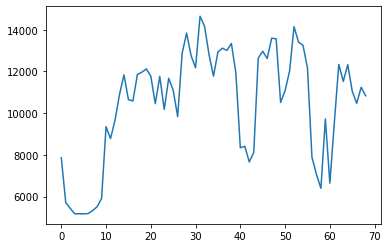

In [29]:
plt.plot(raw_dfs[0].index.values, raw_dfs[0][1600.0])

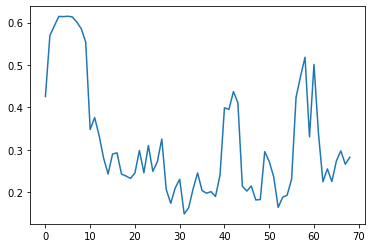

In [30]:
plt.plot(dfs[0].index.values, dfs[0][1600.0])